In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import torch
import numpy as np
from math import *
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import cmcrameri.cm as cmc

%matplotlib inline
plt.style.use('/home/beams/B313762/stylesheet.mplstyle')

## Load data + pre-processing

In [2]:
data_folder = '/data/aileen/DONUT_data'

sim_mat = np.load(os.path.join(data_folder, 'sim_data.npy'))

sim_mat = np.reshape(sim_mat, (sim_mat.shape[0]*sim_mat.shape[1]*sim_mat.shape[2], 
                               sim_mat.shape[3], sim_mat.shape[4]))

print('Data shape: ', sim_mat.shape)

strain = np.linspace(-0.005, 0.005, 41)
tilt_lr = np.linspace(-0.05, 0.05, 41)
tilt_ud = np.linspace(-0.1, 0.1, 41)

labels = np.zeros((41, 41, 41, 3))
for p0 in range(labels.shape[0]):
    for p1 in range(labels.shape[1]):
        for p2 in range(labels.shape[2]):
            labels[p0, p1, p2] = np.array([strain[p0], tilt_lr[p1], tilt_ud[p2]])
labels = np.reshape(labels, (labels.shape[0]*labels.shape[1]*labels.shape[2], labels.shape[3]))
labels[:, 0] *= 100
labels[:, 1] *= 10
labels[:, 2] *= 5
labels = np.float32(np.around(labels, 5))

print('Labels shape: ', labels.shape)

# Normalize data from 0 to average experimental single shot maximum value
for i in range(sim_mat.shape[0]):
    sim_mat[i] = (sim_mat[i] / np.max(sim_mat[i])) * 7
print('Normalized min. and max.: ', np.min(sim_mat), np.max(sim_mat))

# Add Poisson noise 
rng = np.random.default_rng()
for i in tqdm(range(sim_mat.shape[0])):
    sim_mat[i] = rng.poisson(sim_mat[i])

sim_mat = sim_mat.astype('float32')

Data shape:  (68921, 64, 64)
Labels shape:  (68921, 3)
Normalized min. and max.:  0.0 7.0


  0%|          | 0/68921 [00:00<?, ?it/s]

In [3]:
# Simulated SXDM scan
print('Loading simulated scan')
sim_sample = np.load(os.path.join(data_folder, 'sim_sample.npy')).astype(np.float32)
sim_sample = np.reshape(sim_sample, (sim_sample.shape[0]*sim_sample.shape[1], sim_sample.shape[2], sim_sample.shape[3]))
sim_sample[np.isnan(sim_sample)] = 0
for i in range(sim_sample.shape[0]):
    sim_sample[i] = (sim_sample[i] / np.max(sim_sample[i])) * 7
    sim_sample[i] = rng.poisson(sim_sample[i])

gt_strain = np.load(os.path.join(data_folder, 'gt_strain.npy'))
gt_tilt_lr = np.load(os.path.join(data_folder, 'gt_tilt_lr.npy'))
gt_tilt_ud = np.load(os.path.join(data_folder, 'gt_tilt_ud.npy'))

print('Loading simulation fit')
sim_strain_fit = np.load(os.path.join(data_folder, 'strain_fit_SIO_fig2.npy'))
sim_tilt_lr_fit = np.load(os.path.join(data_folder, 'tilt_lr_fit_SIO_fig2.npy'))
sim_tilt_ud_fit = np.load(os.path.join(data_folder, 'tilt_ud_fit_SIO_fig2.npy'))

sim_strain_fit = np.reshape(sim_strain_fit, (64, 64))
sim_tilt_lr_fit = np.reshape(sim_tilt_lr_fit, (64, 64))
sim_tilt_ud_fit = np.reshape(sim_tilt_ud_fit, (64, 64))

# Experimental data
print('Loading raw data')
data = np.load(os.path.join(data_folder, 'dataSIO.npy')).astype('float32')

print('Loading fitted data')
folder = '/data/aileen/NanobeamNN/data'
strain = np.load(os.path.join(folder, 'strain_fit190_test.npy'))
tilt_lr = np.load(os.path.join(folder, 'tilt_lr_fit190_test.npy'))
tilt_ud = np.load(os.path.join(folder, 'tilt_ud_fit190_test.npy'))

strain = np.reshape(strain, (165, 165))
tilt_lr = np.reshape(tilt_lr, (165, 165))
tilt_ud = np.reshape(tilt_ud, (165, 165))

strain -= np.mean(strain)
tilt_lr -= np.mean(tilt_lr)
tilt_ud -= np.mean(tilt_ud)

Loading simulated scan
Loading simulation fit
Loading raw data
Loading fitted data


## Convert to PyTorch Dataset

In [4]:
class DiffDataset(Dataset):
    """Makes PyTorch Dataset object for diffraction data (images)."""
    
    def __init__(self, data, params=None, transform=None):
        self.data = data
        if isinstance(params, np.ndarray):
            self.params = params
        else:
            self.params = None
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.data[idx]
        if isinstance(self.params, np.ndarray):
            lattice = self.params[idx]
            sample={'image': image, 'lattice': lattice}
        else:
            sample = {'image': image, 'lattice': None}
            
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert numpy arrays to Tensors"""
    def __call__(self, sample):
        image = sample['image']
        if isinstance(sample['lattice'], np.ndarray):
            lattice = sample['lattice']
            return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': torch.from_numpy(lattice)}
        return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': 0}

In [5]:
diff_dataset = DiffDataset(data=sim_mat, params=labels, transform=ToTensor())
sim_dataset = DiffDataset(data=sim_sample, params=None, transform=ToTensor())
exp_dataset = DiffDataset(data=data, params=None, transform=ToTensor())

for i, sample in enumerate(diff_dataset):
    print(i, sample['image'].size())
    print(sample['image'].dtype)
    
    if i == 4:
        break

0 torch.Size([1, 64, 64])
torch.float32
1 torch.Size([1, 64, 64])
torch.float32
2 torch.Size([1, 64, 64])
torch.float32
3 torch.Size([1, 64, 64])
torch.float32
4 torch.Size([1, 64, 64])
torch.float32


In [6]:
# Split into training, validation, and test sets

generator0 = torch.Generator().manual_seed(8)

subsets = torch.utils.data.random_split(diff_dataset, [0.8, 0.1, 0.1], generator=generator0)

## Hyperparameters and constants

In [7]:
BATCH_SIZE = 16
MODEL_SAVE_PATH = '/home/beams/AILEENLUO/DONUT/models'

In [8]:
# Use a DataLoader to iterate through the Dataset
trainloader = DataLoader(subsets[0], batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(subsets[1], batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(subsets[2], batch_size=BATCH_SIZE, shuffle=False)

simloader = DataLoader(sim_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloader = DataLoader(exp_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model definition

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x: torch.Tensor):
        return self.conv(x)

# Autoencoder building blocks
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, x: torch.Tensor):
        return self.pool(x)
    
class UpSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
    def forward(self, x: torch.Tensor):
        return self.up(x)
    
class DoubleConvUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x: torch.Tensor):
        return self.conv(x)

In [10]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int, dropout_rate=0.0):
        super().__init__()
        self.down_conv = nn.ModuleList([DoubleConv(i, o, dropout_rate) for i, o in 
                                        [(in_channels, 16), (16, 32), (32, 64), (64, 128), (128, 256), 
                                         (256, 256)]])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(6)])
        self.fc = nn.Linear(256, 3)
        
    def forward(self, x: torch.Tensor):
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            x = self.down_sample[i](x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.up_sample = UpSample()
        self.up_conv = nn.ModuleList([DoubleConvUp(i, o, dropout_rate) for i, o in 
                                      [(256, 256), (256, 128), (128, 64), (64, 32), (32, 16), 
                                       (16, out_channels)]])
        self.inv_fc = nn.Linear(3, 256)
        
    def forward(self, x: torch.Tensor):
        x = self.inv_fc(x)
        x = x.view(x.shape[0], 256, 1, 1)
        for i in range(len(self.up_conv)):
            x = self.up_sample(x)
            x = self.up_conv[i](x)
        return x

In [11]:
class DonutNN2(nn.Module):
    """Version with Tao's new forward model."""
    
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0, **kwargs):
        super().__init__()
        
        self.upsampling = kwargs.get('upsampling', 2) # Upsampling factor for reciprocal space
        self.energy = kwargs.get('energy', 11.3) # X-ray energy in keV
        self.c = kwargs.get('c', 4.013) # Lattice constant in Angstroms
        self.l = kwargs.get('l', 2) # l from hkl Bragg peak
        self.thickness = kwargs.get('thickness', 117) # Film thickness in Angstroms
        self.X0 = kwargs.get('X0', 256) # Pixel coordinate of the center of Bragg peak
        self.Xcen = kwargs.get('Xcen', 256) # Pixel coordinate of the center of ZP reflection on detector
        self.zp_diameter = kwargs.get('zp_diameter', 149e-6) # Zone plate diameter in meters
        self.cs_diameter = kwargs.get('cs_diameter', 77e-6) # Central beam stop diameter in meters
        self.outer_zone_width = kwargs.get('outer_zone_width', 16e-9) # Outermost zone width in meters
        self.distance = kwargs.get('distance', 0.85) # Detector distance from sample in meters
        self.pixelsize = kwargs.get('pixelsize', 55e-6*2) # Detector pixel size in meters (*2 for binning)
        
        # Some more parameters that depend on those above
        self.wavelength = 12.398/self.energy # X-ray wavelength in Angstroms
        self.K = 2*pi/self.wavelength
        self.alf = asin(self.wavelength*self.l/2/self.c) # Incident angle in radians
        self.gam0 = asin(self.wavelength*self.l/self.c-sin(self.alf)) # Exit angle in radians
        self.focal_length = (self.zp_diameter*self.outer_zone_width)/(self.wavelength*1e-10) # ZP-sample distance (m)
        self.outer_angle = self.zp_diameter/2/self.focal_length
        self.inner_angle = self.cs_diameter/2/self.focal_length
        self.wx = self.K*self.pixelsize/self.distance/10 # FWHM of Gaussian function describing Bragg peak in qx
        self.wy = self.K*self.pixelsize/self.distance/10 # FWHM of Gaussian function describing Bragg peak in qy
        
        # Detector and reciprocal space
        gam, det_Qx, det_Qz, det_Qy = self.detector_space()
        self.register_buffer('gam', gam, persistent=False) # Should not need register buffer in PyTorch 2
        self.register_buffer('det_Qx', det_Qx, persistent=False)
        self.register_buffer('det_Qz', det_Qz, persistent=False)
        self.register_buffer('det_Qy', det_Qy, persistent=False)
        O_Qx, O_Qz, O_Qy = self.recip_space()
        self.register_buffer('O_Qx', O_Qx, persistent=False)
        self.register_buffer('O_Qz', O_Qz, persistent=False)
        self.register_buffer('O_Qy', O_Qy, persistent=False)
        
        # Initialize autoencoder
        self.encoder = Encoder(in_channels, dropout_rate)
        self.decoder = Decoder(out_channels, dropout_rate)
        
        self.epoch = 0
        
    def detector_space(self):
        det_x = np.arange(64).astype(np.float32)
        det_y = np.arange(64).astype(np.float32)
        det_x = det_x - det_x.mean() + self.X0 - (self.X0-self.Xcen)
        det_y -= det_y.mean()
        det_xx, det_yy = np.meshgrid(det_x, det_y)
        gam = np.arcsin((det_xx-self.X0)*self.pixelsize/self.distance)+self.gam0
        gam = torch.Tensor(gam)
        det_Qx = torch.Tensor(self.K*(np.cos(self.alf)-np.cos(gam)))
        det_Qz = torch.Tensor(self.K*(np.sin(gam)+np.sin(self.alf)))
        det_Qy = torch.Tensor(det_yy*self.pixelsize/self.distance*self.K)
        return gam, det_Qx, det_Qz, det_Qy
    
    def recip_space(self):
        O_x = np.arange(64*self.upsampling).astype(np.float32)
        O_y = np.arange(64*self.upsampling).astype(np.float32)
        O_x -= O_x.mean()
        O_y -= O_y.mean()
        O_xx, O_yy = np.meshgrid(O_x, O_y)
        O_xx = O_xx[:, :, np.newaxis, np.newaxis]
        O_yy = O_yy[:, :, np.newaxis, np.newaxis]
        O_Qx = -O_xx*self.pixelsize/self.upsampling/self.distance*self.K*sin(self.alf)
        O_Qz = O_xx*self.pixelsize/self.upsampling/self.distance*self.K*cos(self.alf)
        O_Qy = O_yy*self.pixelsize/self.upsampling/self.distance*self.K
        # Zone plate effects
        O_angle = np.sqrt(O_yy**2+O_xx**2)*self.pixelsize/self.upsampling/self.distance
        O_donut = (O_angle < self.outer_angle) * (O_angle > self.inner_angle)
        O_Qx = torch.Tensor(O_Qx[O_donut][:, np.newaxis, np.newaxis])
        O_Qy = torch.Tensor(O_Qy[O_donut][:, np.newaxis, np.newaxis])
        O_Qz = torch.Tensor(O_Qz[O_donut][:, np.newaxis, np.newaxis])
        return O_Qx, O_Qz, O_Qy
    
    def forward(self, x: torch.Tensor):
        
        # Encoder
        x = self.encoder(x)
        
        # Constrain output space
        strain_tensor = 1.7159 * torch.tanh((2/3) * x) # LeCun, et al. Efficient BackProp 1998
        
        # Decoder
        recon = self.decoder(strain_tensor)
        
        # X-ray scattering model
        det_Qz = torch.tile(self.det_Qz, (strain_tensor.shape[0], 1, 1))
        det_Qz = det_Qz[:, None, :, :]
        det_Qx = torch.tile(self.det_Qx, (strain_tensor.shape[0], 1, 1))
        det_Qx = det_Qx[:, None, :, :]
        det_Qy = torch.tile(self.det_Qy, (strain_tensor.shape[0], 1, 1))
        det_Qy = det_Qy[:, None, :, :]
        
        O_Qz = torch.tile(self.O_Qz, (strain_tensor.shape[0], 1, 1, 1))
        O_Qx = torch.tile(self.O_Qx, (strain_tensor.shape[0], 1, 1, 1))
        O_Qy = torch.tile(self.O_Qy, (strain_tensor.shape[0], 1, 1, 1))
        
        strain = strain_tensor[:, 0]/100
        strain = strain.view(strain_tensor.shape[0], 1, 1, 1)
        tilt_lr = torch.deg2rad(strain_tensor[:, 1]/10)
        tilt_lr = tilt_lr.view(strain_tensor.shape[0], 1, 1, 1)
        tilt_ud = torch.deg2rad(strain_tensor[:, 2]/5)
        tilt_ud = tilt_ud.view(strain_tensor.shape[0], 1, 1, 1)
        
        qx = det_Qx+2*pi/self.c*self.l/(1+strain)*tilt_lr-O_Qx
        qy = det_Qy+2*pi/self.c*self.l/(1+strain)*tilt_ud-O_Qy
        qz = det_Qz-2*pi/self.c*self.l/(1+strain)-O_Qz
        
        I = self.thickness*torch.sinc(self.thickness*qz/pi/2)**2 *\
            torch.exp(-qx**2/self.wx**2) * torch.exp(-qy**2/self.wy**2)
        intensity = I.sum(1)
        sim_norm = (intensity / intensity.max(1, keepdims=True).values.max(2, keepdims=True).values) * 7
        sim_norm = sim_norm[:, None, :, :]
        
        self.epoch += 1
        
        return recon, sim_norm, strain_tensor
        

In [12]:
from torchinfo import summary

cnn = DonutNN2(1, 1, 0.1)
# Summarize the layers and corresponding dimensions/parameters
summary(cnn, (1, 1, 64, 64), device='cpu')

Layer (type:depth-idx)                             Output Shape              Param #
DonutNN2                                           [1, 1, 64, 64]            --
├─Encoder: 1-1                                     [1, 3]                    --
│    └─ModuleList: 2-11                            --                        (recursive)
│    │    └─DoubleConv: 3-1                        [1, 16, 64, 64]           2,544
│    └─ModuleList: 2-12                            --                        --
│    │    └─DownSample: 3-2                        [1, 16, 32, 32]           --
│    └─ModuleList: 2-11                            --                        (recursive)
│    │    └─DoubleConv: 3-3                        [1, 32, 32, 32]           14,016
│    └─ModuleList: 2-12                            --                        --
│    │    └─DownSample: 3-4                        [1, 32, 16, 16]           --
│    └─ModuleList: 2-11                            --                        (recursive)
│

In [13]:
# Check that there are no errors in dimensions
for i, data in enumerate(trainloader):
    inputs = data['image']
    print("inputs:", inputs.shape)
    outputs = cnn(inputs)
    print("outputs:", outputs[0].shape, outputs[1].shape)
    break

inputs: torch.Size([16, 1, 64, 64])
outputs: torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


## Inference

In [14]:
cnn = DonutNN2(1, 1) # Full model for image comparisons, 'best_model.pth'
#cnn = Encoder(1) # Encoder for fast inference, best_model_encoder.pth'
run_path = os.path.join(MODEL_SAVE_PATH, 'sim_noisy_exp')
cnn.load_state_dict(torch.load(os.path.join(run_path, 'best_model.pth')))
next(cnn.parameters()).device

device(type='cpu')

In [15]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"

def get_predictions(model, dataloader, encoder_only=True, batch_size=BATCH_SIZE, device=DEVICE):
    """Returns network predictions and labels by any model on any dataset."""
    
    pred_vals = np.zeros((len(dataloader)-1, batch_size, 3))
    if encoder_only == False:
        pred_imgs = np.zeros((len(dataloader)-1, batch_size, 64, 64))
        pred_recon = np.zeros((len(dataloader)-1, batch_size, 64, 64))
        gt_imgs = np.zeros(pred_imgs.shape)
    gt_vals = np.zeros(pred_vals.shape)
    model.to(device)
    print(next(model.parameters()).device)
    inference_time = []
    t0 = time.time()
    
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader)):
            t1 = time.time()
            images = data['image'].to(device)
            if isinstance(data['lattice'], torch.Tensor):
                labels = data['lattice'].to(device)
            if encoder_only == False:
                output_recon, output_imgs, output_vals = model(images)
            else: 
                output_enc = model(images)
                output_vals = 1.7159 * torch.tanh((2/3) * output_enc)
            if i < pred_vals.shape[0]:
                pred_vals[i] = output_vals.detach().cpu().numpy()
                if encoder_only == False:
                    pred_imgs[i] = output_imgs.squeeze().detach().cpu().numpy()
                    pred_recon[i] = output_recon.squeeze().detach().cpu().numpy()
                    gt_imgs[i] = images.squeeze().detach().cpu().numpy()
                if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 3):
                    gt_vals[i] = labels.detach().cpu().numpy()
                inference_time.append(time.time()-t1)
            else:
                # The last batch may be a different size
                pred_vals_last = output_vals.detach().cpu().numpy()
                gt_vals_last = np.zeros(pred_vals_last.shape)
                if encoder_only == False:
                    pred_imgs_last = output_imgs.squeeze(dim=1).detach().cpu().numpy()
                    pred_recon_last = output_recon.squeeze(dim=1).detach().cpu().numpy()
                    gt_imgs_last = images.squeeze().detach().cpu().numpy()
                    if gt_imgs_last.ndim == 2:
                        gt_imgs_last = gt_imgs_last[np.newaxis, :, :]
                if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 3):
                    gt_vals_last = labels.detach().cpu().numpy()
                inference_time.append(time.time()-t1)
    
    print('Total inference time (s): ', time.time()-t0)
    print('Average inference time (s): ', np.mean(inference_time[2:len(inference_time)-1])/batch_size)
    print('Inference time error (s): ', np.std(inference_time[2:len(inference_time)-1])/batch_size)
    pred_vals = np.reshape(pred_vals, (pred_vals.shape[0]*pred_vals.shape[1], pred_vals.shape[2]))
    if encoder_only == False:
        pred_imgs = np.reshape(pred_imgs, (pred_imgs.shape[0]*pred_imgs.shape[1], 
                                           pred_imgs.shape[2], pred_imgs.shape[3]))
        pred_recon = np.reshape(pred_recon, (pred_recon.shape[0]*pred_recon.shape[1], pred_recon.shape[2],
                                             pred_recon.shape[3]))
        gt_imgs = np.reshape(gt_imgs, (gt_imgs.shape[0]*gt_imgs.shape[1], gt_imgs.shape[2], gt_imgs.shape[3]))
        pred_imgs = np.vstack((pred_imgs, pred_imgs_last))
        pred_recon = np.vstack((pred_recon, pred_recon_last))
        gt_imgs = np.vstack((gt_imgs, gt_imgs_last))
    gt_vals = np.reshape(gt_vals, (gt_vals.shape[0]*gt_vals.shape[1], gt_vals.shape[2]))
    pred_vals = np.vstack((pred_vals, pred_vals_last))
    gt_vals = np.vstack((gt_vals, gt_vals_last))
    if encoder_only == False:
        return pred_vals, pred_imgs, pred_recon, gt_vals, gt_imgs
    return pred_vals, gt_vals

In [16]:
# CHECK WHETHER USING THE ENCODER ONLY OR FULL MODEL!
pred_vals_train, pred_imgs_train, pred_recon_train, gt_vals_train, gt_imgs_train = get_predictions(cnn, 
                                                                                                   trainloader, 
                                                                                                   encoder_only=False) 
pred_vals_test, pred_imgs_test, pred_recon_test, gt_vals_test, gt_imgs_test = get_predictions(cnn, testloader, 
                                                                                              encoder_only=False)

# pred_vals_train, gt_vals_train = get_predictions(cnn, trainloader, encoder_only=True)
# pred_vals_test, gt_vals_test = get_predictions(cnn, testloader, encoder_only=True)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  282.12341713905334
Average inference time (s):  0.004913584717509361
Inference time error (s):  1.4041315983487781e-05
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  34.175344705581665
Average inference time (s):  0.004915714368363407
Inference time error (s):  1.4226660736341278e-05


In [17]:
pred_vals_sim, pred_imgs_sim, pred_recon_sim, _, gt_imgs_sim = get_predictions(cnn, simloader, encoder_only=False)
#pred_vals_sim, _ = get_predictions(cnn, simloader, encoder_only=True)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  20.27320647239685
Average inference time (s):  0.004917706484379975
Inference time error (s):  7.84038994368179e-06


In [18]:
pred_vals_exp, pred_imgs_exp, pred_recon_exp, _, gt_imgs_exp = get_predictions(cnn, dataloader, encoder_only=False)
#pred_vals_exp, _ = get_predictions(cnn, dataloader, encoder_only=True)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  134.90363955497742
Average inference time (s):  0.004921078418829358
Inference time error (s):  1.3007289753699801e-05


## With diffraction generation (skip to Statistics if using encoder only)

In [19]:
idx_exp = np.array([12385, 13650])
plot_exp_imgs = np.zeros((2, 64, 64))
plot_pred_exp = np.zeros((2, 64, 64))
plot_exp_recon = np.zeros((2, 64, 64))
for i in range(len(idx_exp)):
    plot_exp_imgs[i] = gt_imgs_exp[idx_exp[i]]
    plot_pred_exp[i] = pred_imgs_exp[idx_exp[i]]
    plot_exp_recon[i] = pred_recon_exp[idx_exp[i]]

Text(0.5, 1.0, 'Recon. 1')

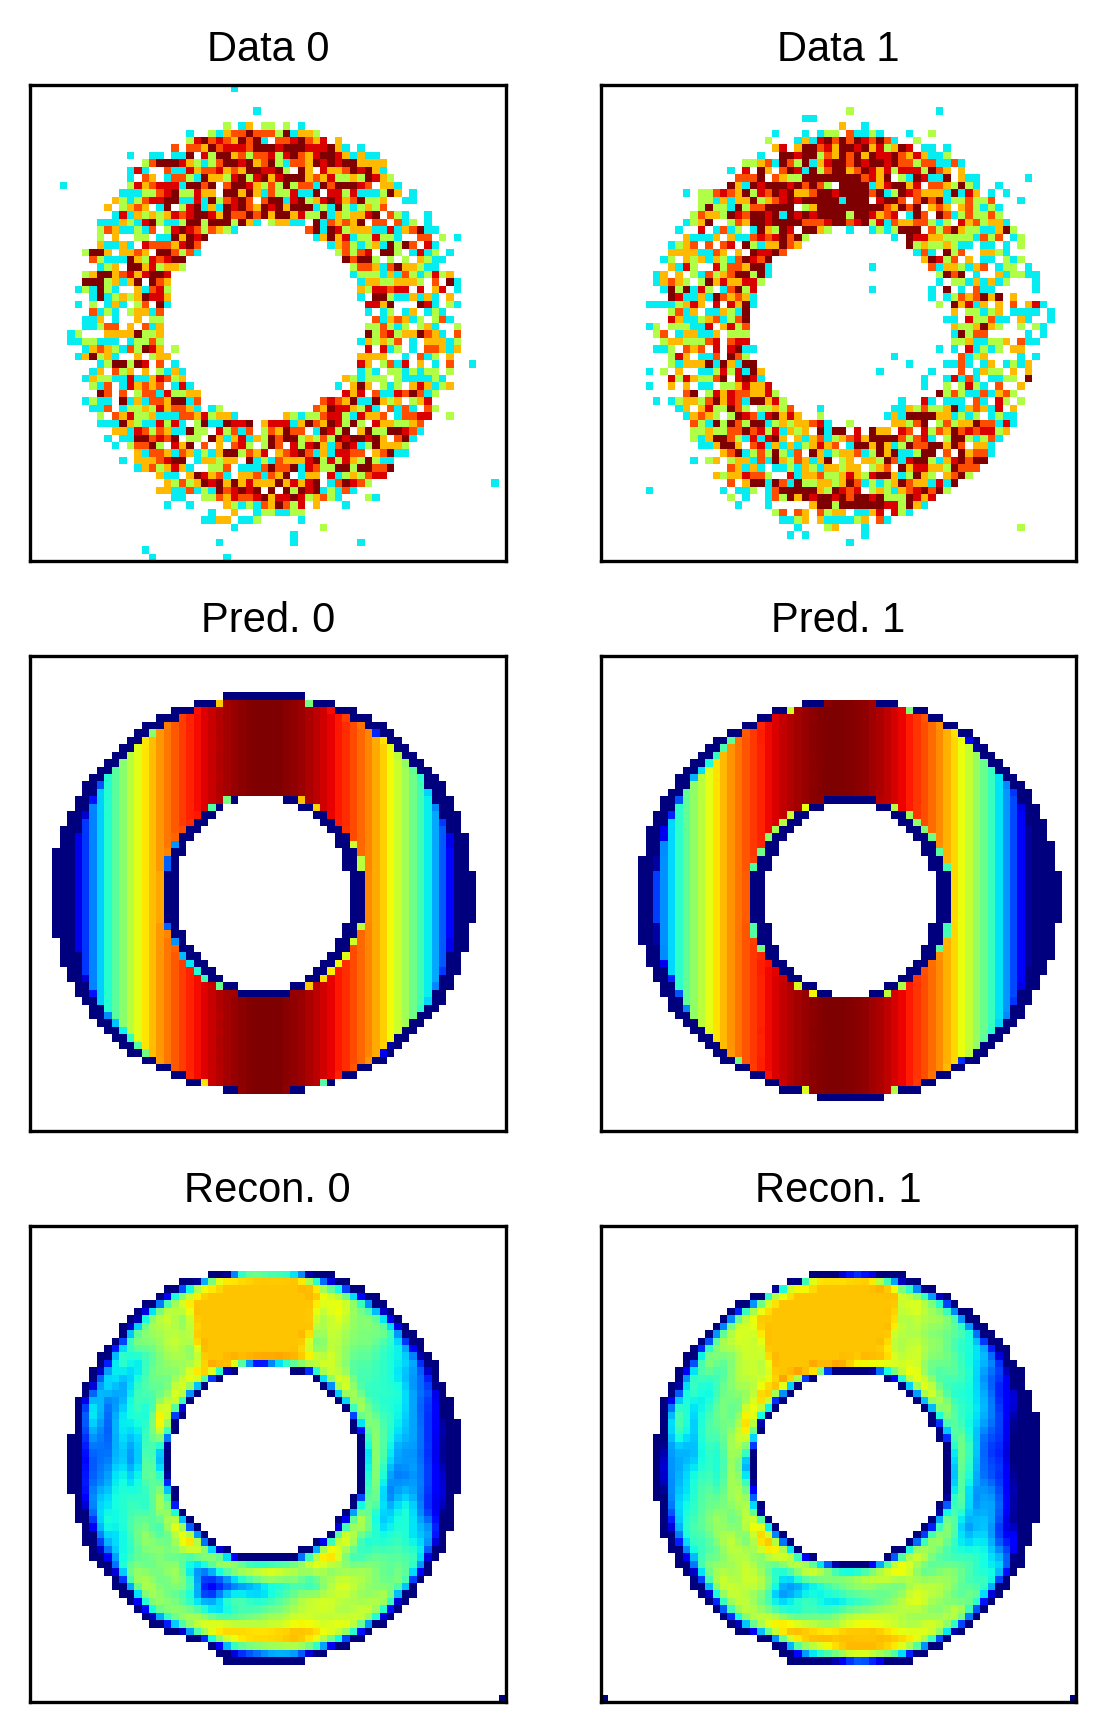

In [20]:
vmin = 1
vmax = 7
normalizer = colors.LogNorm(vmin, vmax)
im = cm.ScalarMappable(norm=normalizer, cmap='jet')

f, ax = plt.subplots(figsize=(4.5, 7), nrows=3, ncols=2)

ax[0, 0].imshow(plot_exp_imgs[0], interpolation='none', cmap='jet', norm=normalizer)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].set_title('Data 0')

ax[0, 1].imshow(plot_exp_imgs[1], interpolation='none', cmap='jet', norm=normalizer)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 1].set_title('Data 1')

ax[1, 0].imshow(plot_pred_exp[0], interpolation='none', cmap='jet', norm=normalizer)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 0].set_title('Pred. 0')

ax[1, 1].imshow(plot_pred_exp[1], interpolation='none', cmap='jet', norm=normalizer)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 1].set_title('Pred. 1')

ax[2, 0].imshow(plot_exp_recon[0], interpolation='none', cmap='jet', norm=normalizer)
ax[2, 0].set_xticks([])
ax[2, 0].set_yticks([])
ax[2, 0].set_title('Recon. 0')

ax[2, 1].imshow(plot_exp_recon[1], interpolation='none', cmap='jet', norm=normalizer)
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])
ax[2, 1].set_title('Recon. 1')

In [21]:
idx_list = np.array([183, 1046, 5021, 5706])

plot_pred_imgs = np.zeros((4, 64, 64))
plot_gt_imgs = np.zeros((4, 64, 64))
plot_pred_recon = np.zeros((4, 64, 64))
plot_pred_vals = np.zeros((4, 3))
plot_gt_vals = np.zeros((4, 3))
for i in range(len(idx_list)):
    plot_pred_imgs[i] = pred_imgs_test[idx_list[i]]
    plot_pred_recon[i] = pred_recon_test[idx_list[i]]
    plot_gt_imgs[i] = gt_imgs_test[idx_list[i]]
    plot_pred_vals[i] = pred_vals_test[idx_list[i]]
    plot_gt_vals[i] = gt_vals_test[idx_list[i]]

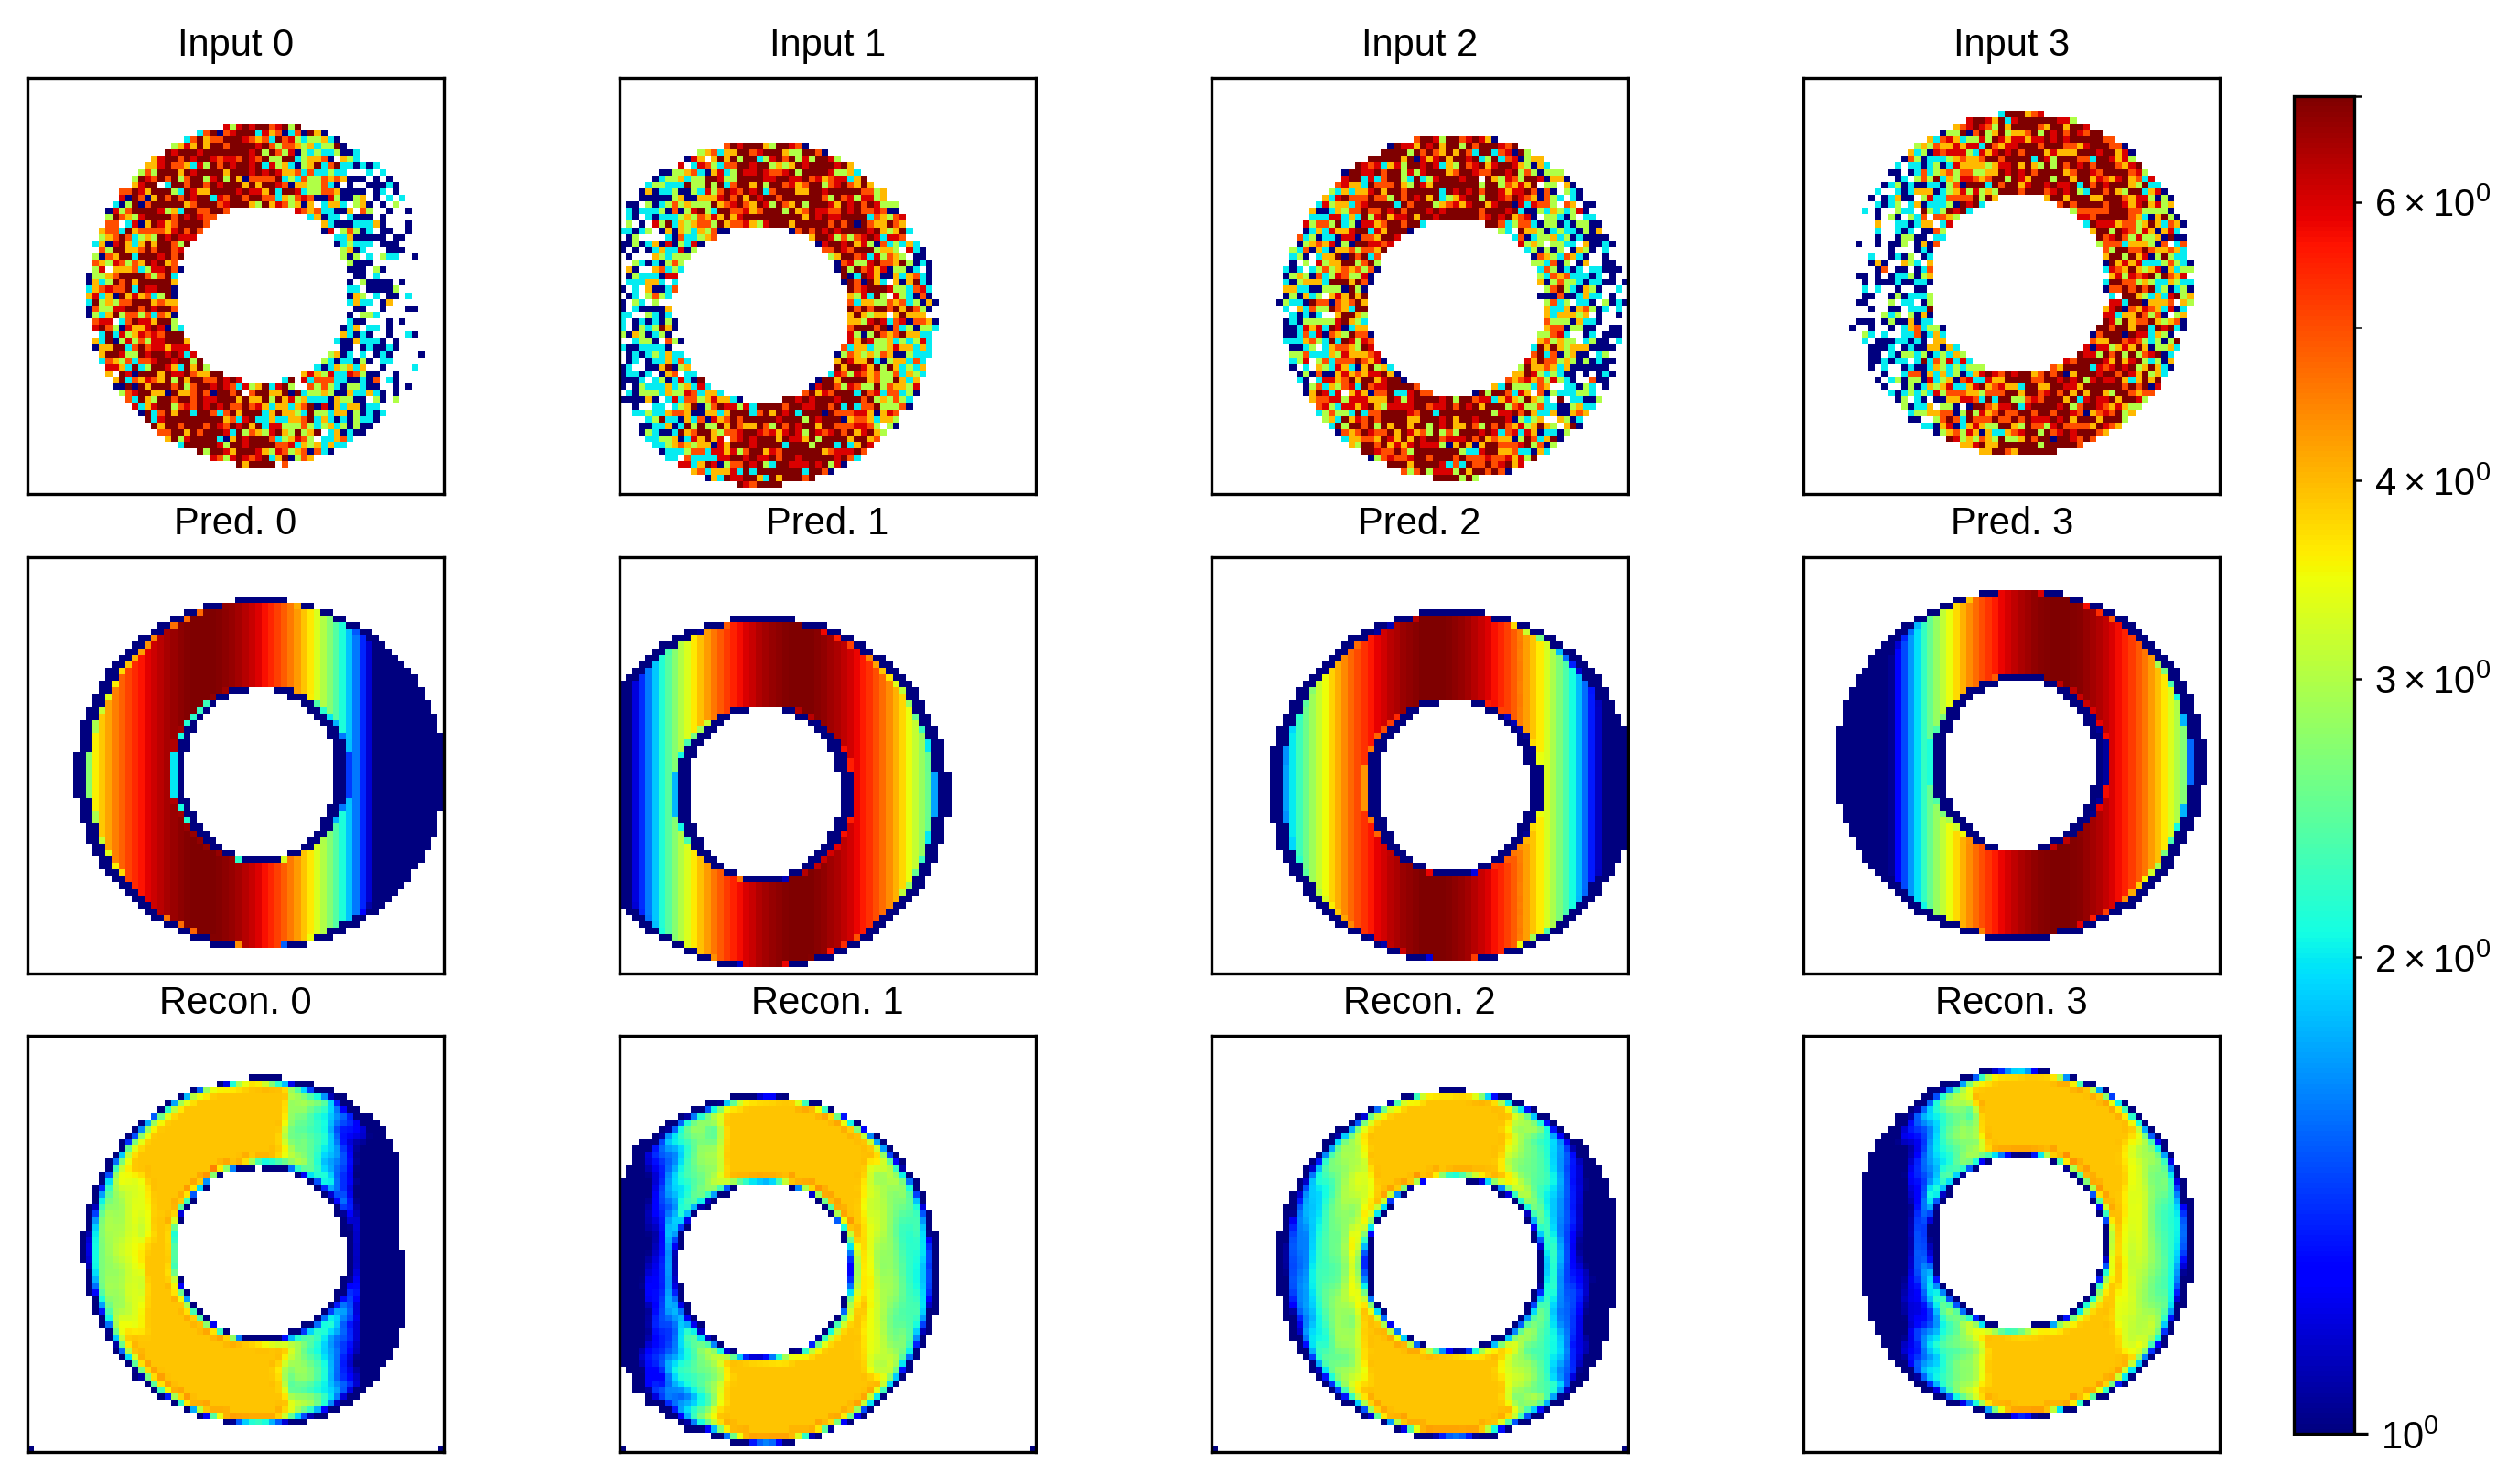

In [22]:
vmin = 1
vmax = 7
normalizer = colors.LogNorm(vmin, vmax)
im = cm.ScalarMappable(norm=normalizer, cmap='jet')

f, ax = plt.subplots(figsize=(11, 6.5), nrows=3, ncols=4)

ax[0, 0].imshow(plot_gt_imgs[0], interpolation='none', cmap='jet', norm=normalizer)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].set_title('Input 0')

ax[0, 1].imshow(plot_gt_imgs[1], interpolation='none', cmap='jet', norm=normalizer)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 1].set_title('Input 1')

ax[0, 2].imshow(plot_gt_imgs[2], interpolation='none', cmap='jet', norm=normalizer)
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])
ax[0, 2].set_title('Input 2')

ax[0, 3].imshow(plot_gt_imgs[3], interpolation='none', cmap='jet', norm=normalizer)
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])
ax[0, 3].set_title('Input 3')

ax[1, 0].imshow(plot_pred_imgs[0], interpolation='none', cmap='jet', norm=normalizer)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 0].set_title('Pred. 0')

ax[1, 1].imshow(plot_pred_imgs[1], interpolation='none', cmap='jet', norm=normalizer)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 1].set_title('Pred. 1')

ax[1, 2].imshow(plot_pred_imgs[2], interpolation='none', cmap='jet', norm=normalizer)
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])
ax[1, 2].set_title('Pred. 2')

ax[1, 3].imshow(plot_pred_imgs[3], interpolation='none', cmap='jet', norm=normalizer)
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])
ax[1, 3].set_title('Pred. 3')

ax[2, 0].imshow(plot_pred_recon[0], interpolation='none', cmap='jet', norm=normalizer)
ax[2, 0].set_xticks([])
ax[2, 0].set_yticks([])
ax[2, 0].set_title('Recon. 0')

ax[2, 1].imshow(plot_pred_recon[1], interpolation='none', cmap='jet', norm=normalizer)
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])
ax[2, 1].set_title('Recon. 1')

ax[2, 2].imshow(plot_pred_recon[2], interpolation='none', cmap='jet', norm=normalizer)
ax[2, 2].set_xticks([])
ax[2, 2].set_yticks([])
ax[2, 2].set_title('Recon. 2')

ax[2, 3].imshow(plot_pred_recon[3], interpolation='none', cmap='jet', norm=normalizer)
ax[2, 3].set_xticks([])
ax[2, 3].set_yticks([])
ax[2, 3].set_title('Recon. 3')

f.subplots_adjust(hspace=0.15, wspace=0.05, right=0.9)
cbar_ax = f.add_axes([0.90, 0.12, 0.02, 0.75])
f.colorbar(im, cax=cbar_ax)
plt.show()

In [23]:
import pandas as pd

input_df = pd.DataFrame({'strain': plot_gt_vals[:, 0]/100, 'tilt_lr': plot_gt_vals[:, 1]/10, 
                         'tilt_ud': plot_gt_vals[:, 2]/5})
pred_df = pd.DataFrame({'strain': plot_pred_vals[:, 0]/100, 'tilt_lr': plot_pred_vals[:, 1]/10, 
                        'tilt_ud': plot_pred_vals[:, 2]/5})

display(input_df, pred_df)

,strain,tilt_lr,tilt_ud
0,0.00325,-0.0150,-0.015
1,-0.00025,0.0375,-0.060
2,0.00025,-0.0200,-0.045
3,-0.00300,-0.0050,0.005


,strain,tilt_lr,tilt_ud
0,0.003106,-0.014552,-0.018273
1,-0.000262,0.036253,-0.057081
2,0.000169,-0.019289,-0.043600
3,-0.003084,-0.004606,0.002501


## Statistics

In [24]:
# Simulated data
pred_sim_strain = np.reshape(pred_vals_sim[:, 0]/100, (64, 64))
pred_sim_tilt_lr = np.reshape(pred_vals_sim[:, 1]/10, (64, 64))
pred_sim_tilt_ud = np.reshape(pred_vals_sim[:, 2]/5, (64, 64))

[]

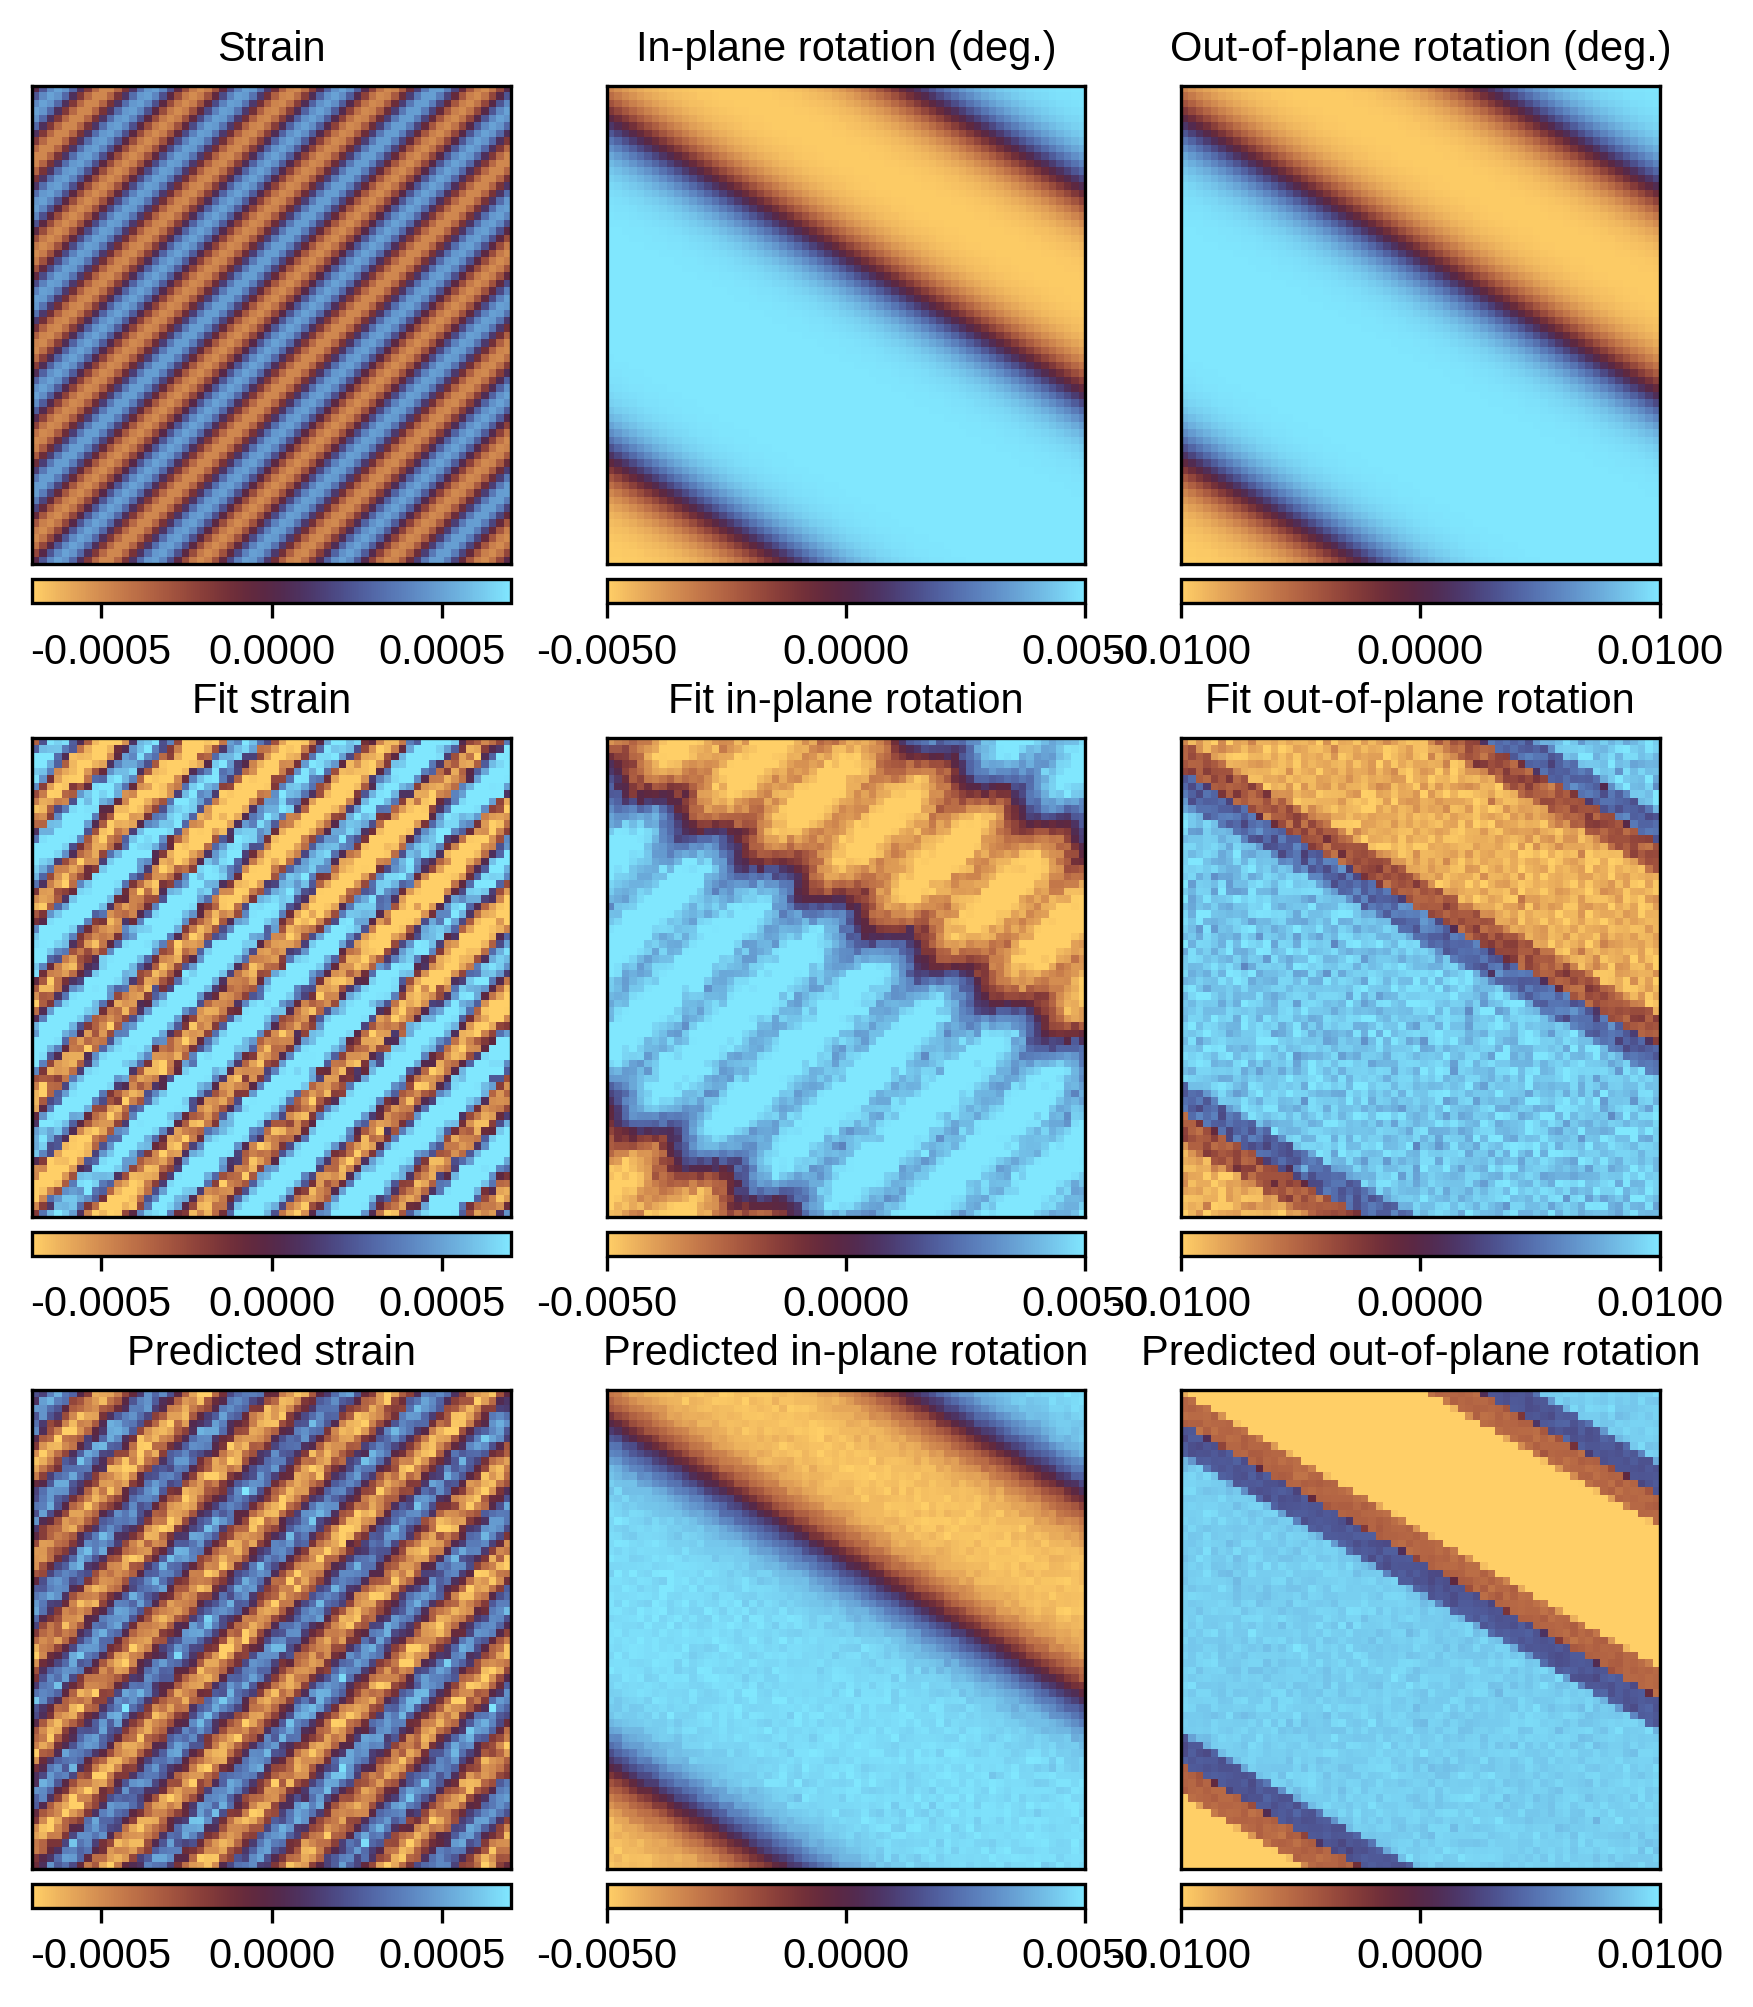

In [25]:
# Refer to Figure 2 of the main text

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 8), nrows=3, ncols=3)

vmin0 = -0.0007
vmax0 = 0.0007
vmin1 = -0.005
vmax1 = 0.005
vmin2 = -0.01
vmax2 = 0.01

im0 = ax[0, 0].imshow(gt_strain, interpolation='none', vmin=vmin0, vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 0].set_title('Strain')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(gt_tilt_lr, interpolation='none', vmin=vmin1, vmax=vmax1, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('In-plane rotation (deg.)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(gt_tilt_ud, interpolation='none', vmin=vmin2, vmax=vmax2, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 2].set_title('Out-of-plane rotation (deg.)')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

fit_im0 = ax[1, 0].imshow(sim_strain_fit, interpolation='none', vmin=vmin0, 
                          vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im0, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 0].set_title('Fit strain')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

fit_im1 = ax[1, 1].imshow(sim_tilt_lr_fit, interpolation='none', vmin=vmin1, vmax=vmax1, 
                          cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Fit in-plane rotation')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

fit_im2 = ax[1, 2].imshow(sim_tilt_ud_fit, interpolation='none', vmin=vmin2, vmax=vmax2, 
                          cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im2, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 2].set_title('Fit out-of-plane rotation')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred_im0 = ax[2, 0].imshow(pred_sim_strain, interpolation='none', vmin=vmin0, vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[2, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im0, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 0].set_title('Predicted strain')
ax[2, 0].set_xticks([])
ax[2, 0].set_yticks([])

pred_im1 = ax[2, 1].imshow(pred_sim_tilt_lr, interpolation='none', vmin=vmin1, vmax=vmax1, cmap=cmc.managua)
divider = make_axes_locatable(ax[2, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im1, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 1].set_title('Predicted in-plane rotation')
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])

pred_im2 = ax[2, 2].imshow(pred_sim_tilt_ud, interpolation='none', vmin=vmin2, vmax=vmax2, cmap=cmc.managua)
divider = make_axes_locatable(ax[2, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im2, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 2].set_title('Predicted out-of-plane rotation')
ax[2, 2].set_xticks([])
ax[2, 2].set_yticks([])

#f.savefig('fig2.svg', dpi=300, bbox_inches='tight', transparent=True)

In [26]:
# Stats
fit_error_strain = sim_strain_fit - gt_strain
print('Avg. strain fit error: ', np.mean(fit_error_strain), '| Std. dev.: ', np.std(fit_error_strain))
fit_error_tilt_lr = sim_tilt_lr_fit - gt_tilt_lr
print('Avg. tilt_lr fit error: ', np.mean(fit_error_tilt_lr), '| Std. dev.: ', np.std(fit_error_tilt_lr))
fit_error_tilt_ud = sim_tilt_ud_fit - gt_tilt_ud
print('Avg. tilt_ud fit error: ', np.mean(fit_error_tilt_ud), '| Std. dev.: ', np.std(fit_error_tilt_ud))

pred_error_strain = pred_sim_strain - gt_strain
print('Avg. strain prediction error: ', np.mean(pred_error_strain), '| Std. dev.: ', np.std(pred_error_strain))
pred_error_tilt_lr = pred_sim_tilt_lr - gt_tilt_lr
print('Avg. tilt_lr prediction error: ', np.mean(pred_error_tilt_lr), '| Std. dev.: ', np.std(pred_error_tilt_lr))
pred_error_tilt_ud = pred_sim_tilt_ud - gt_tilt_ud
print('Avg. tilt_ud prediction error: ', np.mean(pred_error_tilt_ud), '| Std. dev.: ', np.std(pred_error_tilt_ud))

Avg. strain fit error:  9.245947629331813e-05 | Std. dev.:  0.00026063889125210575
Avg. tilt_lr fit error:  -1.0462100745027408e-05 | Std. dev.:  0.000820866028829072
Avg. tilt_ud fit error:  -0.0003426523429283814 | Std. dev.:  0.0014797843484854552
Avg. strain prediction error:  -7.202051893878019e-05 | Std. dev.:  9.759964678678176e-05
Avg. tilt_lr prediction error:  -5.15303249030692e-05 | Std. dev.:  0.00021235096500870582
Avg. tilt_ud prediction error:  -0.000992535497188626 | Std. dev.:  0.0012622623022717106


In [28]:
# Experimental data
pred_strain = np.reshape(pred_vals_exp[:, 0]/100, (165, 165))
pred_strain -= np.mean(pred_strain)
pred_tilt_lr = np.reshape(pred_vals_exp[:, 1]/10, (165, 165))
pred_tilt_lr -= np.mean(pred_tilt_lr)
pred_tilt_ud = np.reshape(pred_vals_exp[:, 2]/5, (165, 165))
pred_tilt_ud -= np.mean(pred_tilt_ud)

[]

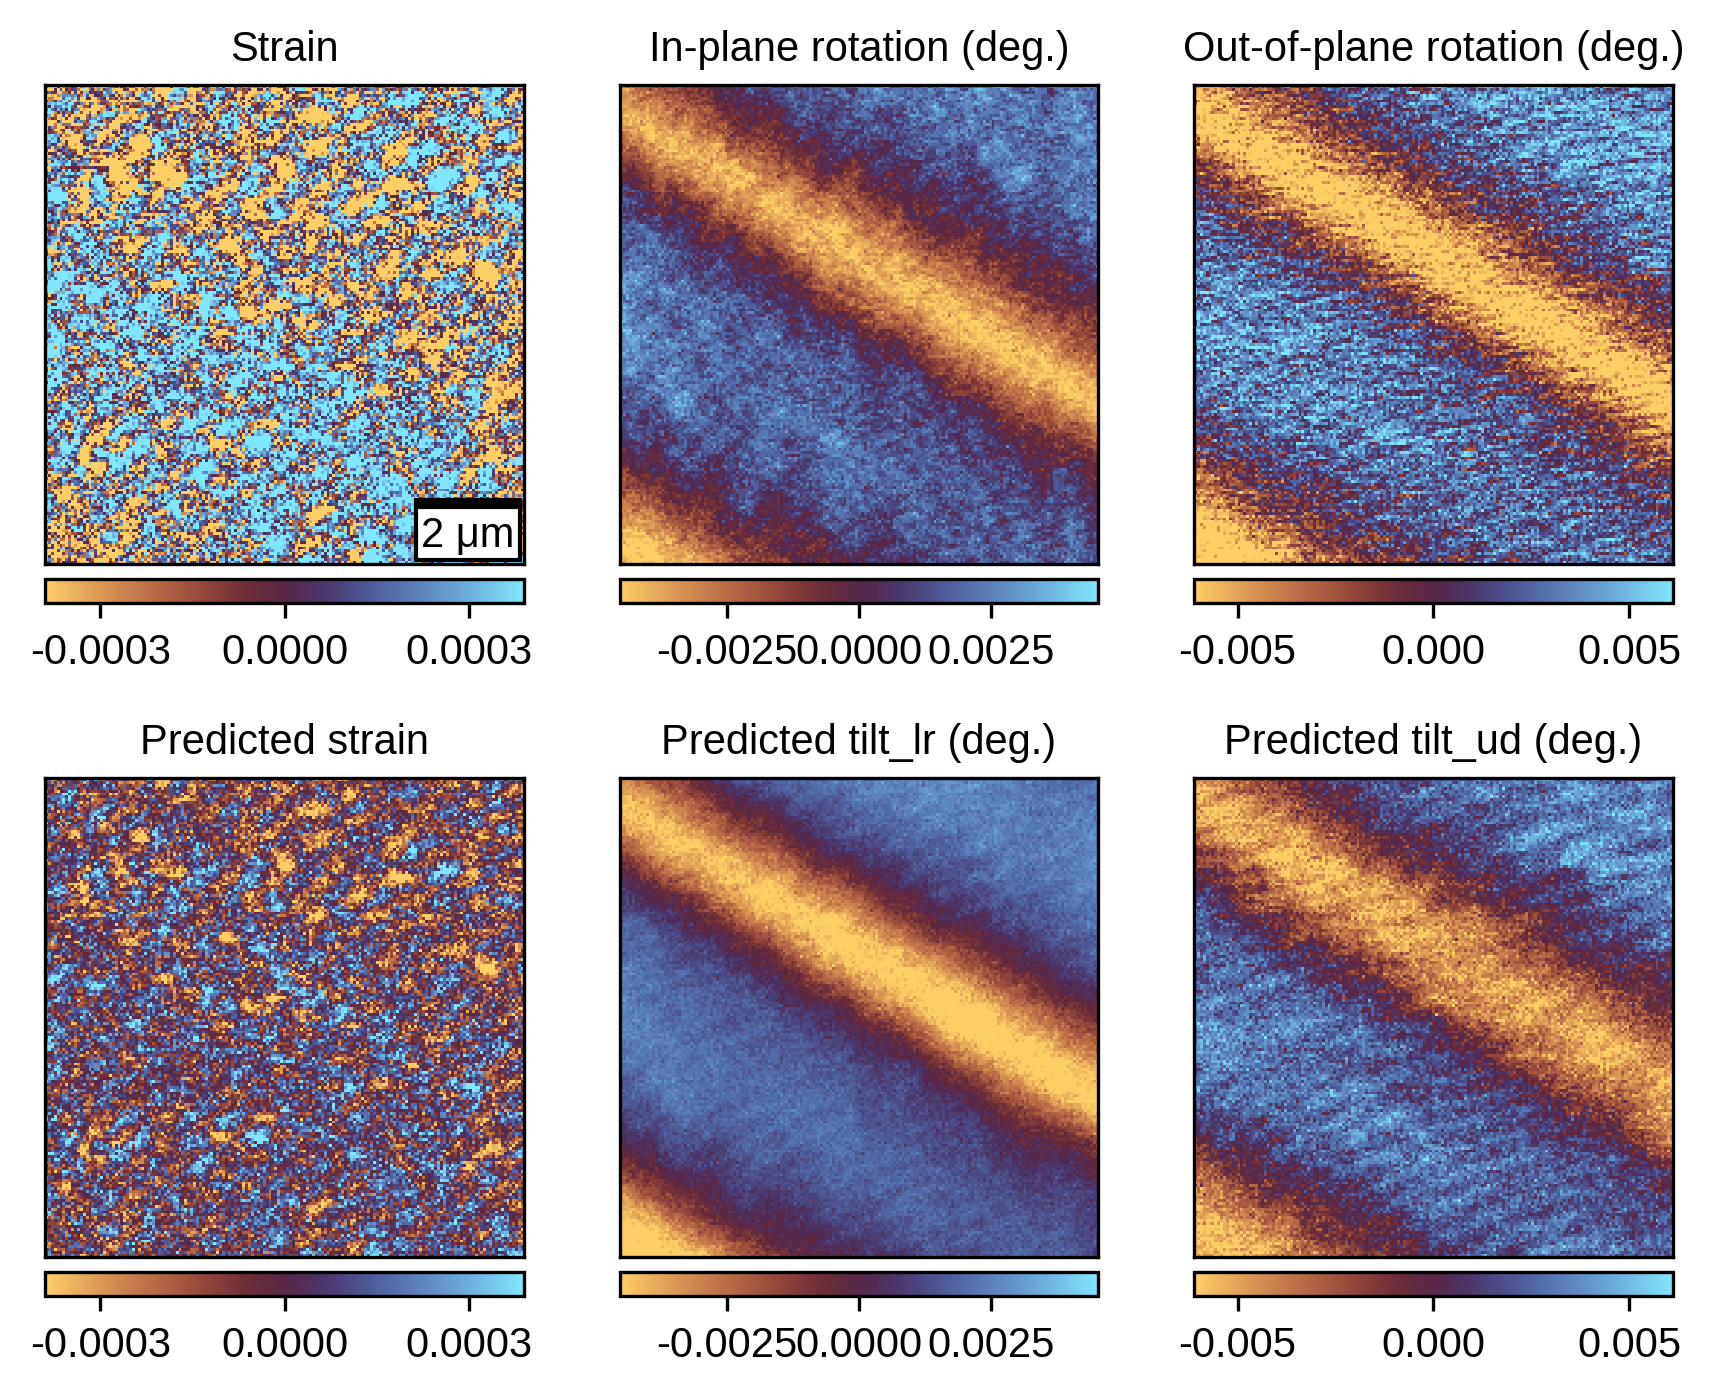

In [29]:
# Refer to Fig. 3

matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 5.5), nrows=2, ncols=3)

vmin0 = np.mean(pred_strain) - (2 * np.std(pred_strain))
vmax0 = np.mean(pred_strain) + (2 * np.std(pred_strain))
vmin1 = np.mean(pred_tilt_lr) - (2 * np.std(pred_tilt_lr))
vmax1 = np.mean(pred_tilt_lr) + (2 * np.std(pred_tilt_lr))
vmin2 = np.mean(pred_tilt_ud) - (2 * np.std(pred_tilt_ud))
vmax2 = np.mean(pred_tilt_ud) + (2 * np.std(pred_tilt_ud))

im0 = ax[0, 0].imshow(strain, interpolation='none', origin='lower', vmin=vmin0, vmax=vmax0, 
                      cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal', format='%.4f')
scalebar = AnchoredSizeBar(ax[0, 0].transData, 33, u'2 μm', 'lower right', pad=0.1, color='black', 
                           frameon=True, size_vertical=1)

ax[0, 0].add_artist(scalebar)
ax[0, 0].set_title('Strain')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(tilt_lr, interpolation='none', origin='lower', vmin=vmin1, vmax=vmax1, 
                      cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('In-plane rotation (deg.)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(tilt_ud, interpolation='none', origin='lower', vmin=vmin2, vmax=vmax2, 
                      cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.3f')
ax[0, 2].set_title('Out-of-plane rotation (deg.)')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

pred0 = ax[1, 0].imshow(pred_strain, interpolation='none', origin='lower', 
                        vmin=vmin0, vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred0, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 0].set_title('Predicted strain')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

pred1 = ax[1, 1].imshow(pred_tilt_lr, interpolation='none', origin='lower', 
                        vmin=vmin1, vmax=vmax1, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Predicted tilt_lr (deg.)')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

pred2 = ax[1, 2].imshow(pred_tilt_ud, interpolation='none', origin='lower', 
                        vmin=vmin2, vmax=vmax2, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred2, cax=cax, orientation='horizontal', format='%.3f')
ax[1, 2].set_title('Predicted tilt_ud (deg.)')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

#f.savefig('fig3.svg', dpi=300, bbox_inches='tight', transparent=True)

In [30]:
from scipy import stats
print(stats.pearsonr(strain.flatten(), pred_strain.flatten())[0])
print(stats.pearsonr(tilt_lr.flatten(), pred_tilt_lr.flatten())[0])
print(stats.pearsonr(tilt_ud.flatten(), pred_tilt_ud.flatten())[0])

0.8790842703711574
0.9612751198272619
0.8938890689861049


In [31]:
strain_label_range = np.linspace(-0.005, 0.005, 41)*100
print('Strain label range (not actual value range): ', strain_label_range)
tilt_lr_label_range = np.linspace(-0.05, 0.05, 41)*10
print('Tilt_lr label range: ', tilt_lr_label_range)
tilt_ud_label_range = np.linspace(-0.1, 0.1, 41)*5
print('Tilt_ud label range: ', tilt_ud_label_range)

Strain label range (not actual value range):  [-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025
  0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475
  0.5  ]
Tilt_lr label range:  [-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025
  0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475
  0.5  ]
Tilt_ud label range:  [-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025
  0.     0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225
  0.25   0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475
  0.5  ]


In [32]:
def make_idx_dict(label_arr):
    """Returns three dictionaries with labels as keys and numpy arrays of indices where the label is the key.
    label_arr: numpy array of labels
    """
    idx_dict_s = dict.fromkeys(strain_label_range)
    idx_dict_lr = dict.fromkeys(tilt_lr_label_range)
    idx_dict_ud = dict.fromkeys(tilt_ud_label_range)
    for strain_label in strain_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 0], 3) == np.around(strain_label, 3))
        idx_dict_s[strain_label] = val_arr
    for lr_label in tilt_lr_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 1], 3) == np.around(lr_label, 3))
        idx_dict_lr[lr_label] = val_arr
    for ud_label in tilt_ud_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 2], 3) == np.around(ud_label, 3))
        idx_dict_ud[ud_label] = val_arr
    return idx_dict_s, idx_dict_lr, idx_dict_ud

def test_make_idx_dict(idx_dict):
    """Return the total number of indices accounted for. It should be equal to the total number of labels."""
    counter = 0
    for key in idx_dict.keys():
        counter += idx_dict[key].shape[0]
    return counter

In [33]:
# Make dictionaries for training and test labels
train_s, train_lr, train_ud = make_idx_dict(gt_vals_train)
print('Train set indices: ', test_make_idx_dict(train_s), test_make_idx_dict(train_lr), 
      test_make_idx_dict(train_ud))
test_s, test_lr, test_ud = make_idx_dict(gt_vals_test)
print('Test set indices: ', test_make_idx_dict(test_s), test_make_idx_dict(test_lr), 
      test_make_idx_dict(test_ud))

Train set indices:  55137 55137 55137
Test set indices:  6892 6892 6892


In [34]:
def get_pred_err_stats(idx_arr, pred_arr, param_num):
    """Returns the mean and standard deviation of the prediction error for all parameters. Helper function for 
    combine_stats.
    idx_arr: array of indices
    pred_arr: array of predictions on a set of data
    param_num: 0 = strain, 1 = tilt_lr, 2 = tilt_ud
    """
    temp = np.zeros((idx_arr.shape[0], ))
    j = 0
    for idx in idx_arr:
        temp[j] = pred_arr[idx[0], param_num]
        j += 1
    return np.mean(temp), np.std(temp)

def combine_stats(idx_dict_s, idx_dict_lr, idx_dict_ud, pred_arr):
    """Combines the prediction errors of a parameter into an array using indices taken from the keys of the
    index dictionaries.
    idx_dict_s: dictionary of strain label values (keys) and index positions (values)
    idx_dict_lr: dictionary of tilt_lr label values and index positions
    idx_dict_ud: dictionary of tilt_ud label values and index positions
    pred_arr: array of predictions on a set of data
    """
    stats_arr_s = np.zeros((len(idx_dict_s), 2))
    stats_arr_lr = np.zeros((len(idx_dict_lr), 2))
    stats_arr_ud = np.zeros((len(idx_dict_ud), 2))
    counter_s = 0
    counter_lr = 0
    counter_ud = 0
    for key in idx_dict_s.keys():
        i_arr = idx_dict_s[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 0)
        stats_arr_s[counter_s, 0] = avg
        stats_arr_s[counter_s, 1] = stddev
        counter_s += 1
    for key in idx_dict_lr.keys():
        i_arr = idx_dict_lr[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 1)
        stats_arr_lr[counter_lr, 0] = avg
        stats_arr_lr[counter_lr, 1] = stddev
        counter_lr += 1
    for key in idx_dict_ud.keys():
        i_arr = idx_dict_ud[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 2)
        stats_arr_ud[counter_ud, 0] = avg
        stats_arr_ud[counter_ud, 1] = stddev
        counter_ud += 1
    return stats_arr_s, stats_arr_lr, stats_arr_ud

In [35]:
# Make arrays of mean and std. dev. of predictions for each parameter and label value for ease of plotting

train_stats_s, train_stats_lr, train_stats_ud = combine_stats(train_s, train_lr, train_ud, pred_vals_train)
test_stats_s, test_stats_lr, test_stats_ud = combine_stats(test_s, test_lr, test_ud, pred_vals_test)

Text(0.5, 0.98, 'Parity plots')

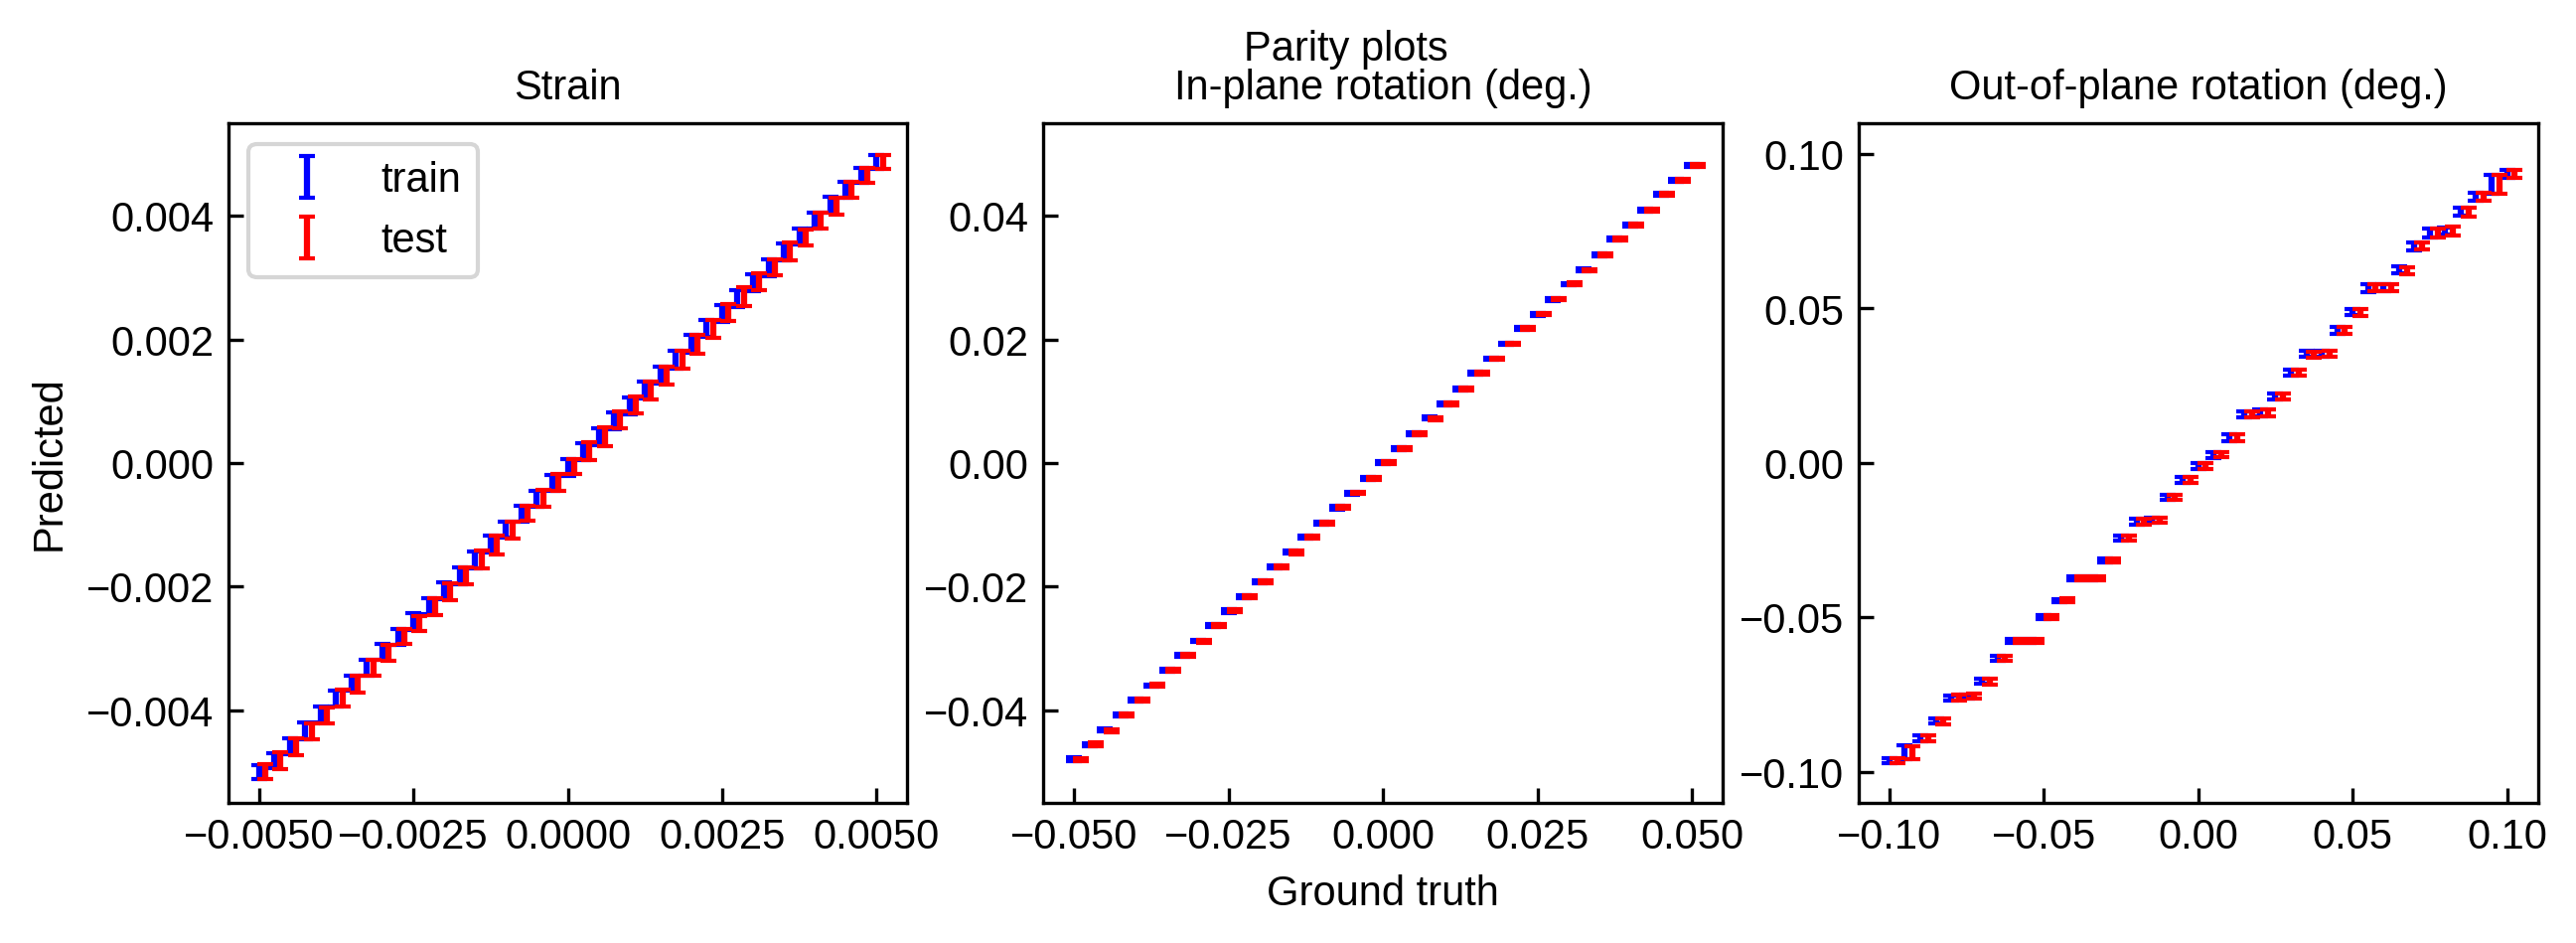

In [36]:
# Fig. S1a

matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(10, 3), ncols=3)

ax[0].errorbar(np.linspace(-0.005, 0.005, 41), train_stats_s[:, 0]/100, yerr=train_stats_s[:, 1]/100, 
               label='train', fmt='none', capsize=2, color='blue')
ax[0].errorbar(np.linspace(-0.005, 0.005, 41)+0.0001, test_stats_s[:, 0]/100, 
               yerr=test_stats_s[:, 1]/100, label='test', fmt='none', capsize=2, color='red')
ax[0].set_ylabel('Predicted')
ax[0].set_xlim([-0.0055, 0.0055])
ax[0].set_ylim([-0.0055, 0.0055])
ax[0].set_title('Strain')
ax[0].set_aspect(1)
ax[0].tick_params(which='both', direction='in')
ax[0].legend()

ax[1].errorbar(np.linspace(-0.05, 0.05, 41), train_stats_lr[:, 0]/10, yerr=train_stats_lr[:, 1]/10, 
               label='train', fmt='none', capsize=2, color='blue')
ax[1].errorbar(np.linspace(-0.05, 0.05, 41)+0.001, test_stats_lr[:, 0]/10, yerr=test_stats_lr[:, 1]/10, 
               label='test', fmt='none', capsize=2, color='red')
ax[1].set_xlabel('Ground truth')
ax[1].set_xlim([-0.055, 0.055])
ax[1].set_ylim([-0.055, 0.055])
ax[1].set_title('In-plane rotation (deg.)')
ax[1].tick_params(which='both', direction='in')
ax[1].set_aspect(1)

ax[2].errorbar(np.linspace(-0.1, 0.1, 41), train_stats_ud[:, 0]/5, yerr=train_stats_ud[:, 1]/5, 
               label='train', fmt='none', capsize=2, color='blue')
ax[2].errorbar(np.linspace(-0.1, 0.1, 41)+0.0025, test_stats_ud[:, 0]/5, yerr=test_stats_ud[:, 1]/5, 
               label='test', fmt='none', capsize=2, color='red')
ax[2].set_title('Out-of-plane rotation (deg.)')
ax[2].set_xlim([-0.11, 0.11])
ax[2].set_ylim([-0.11, 0.11])
ax[2].tick_params(which='both', direction='in')
ax[2].set_aspect(1)

f.suptitle('Parity plots')
#f.savefig('figs1a.svg', dpi=300, bbox_inches='tight', transparent=True)

In [37]:
x0 = pred_vals_train[:, 0]/100 - gt_vals_train[:, 0]/100
y0 = pred_vals_test[:, 0]/100 - gt_vals_test[:, 0]/100
range0 = np.max([np.abs(x0.min()), np.abs(x0.max()), np.abs(y0.min()), np.abs(y0.max())])
bins0 = np.linspace(-range0, range0, 20)

x1 = pred_vals_train[:, 1]/10 - gt_vals_train[:, 1]/10
y1 = pred_vals_test[:, 1]/10 - gt_vals_test[:, 1]/10
range1 = np.max([np.abs(x1.min()), np.abs(x1.max()), np.abs(y1.min()), np.abs(y1.max())])
bins1 = np.linspace(-range1, range1, 20)

x2 = pred_vals_train[:, 2]/5 - gt_vals_train[:, 2]/5
y2 = pred_vals_test[:, 2]/5 - gt_vals_test[:, 2]/5
range2 = np.max([np.abs(x2.min()), np.abs(x2.max()), np.abs(y2.min()), np.abs(y2.max())])
bins2 = np.linspace(-range2, range2, 20)

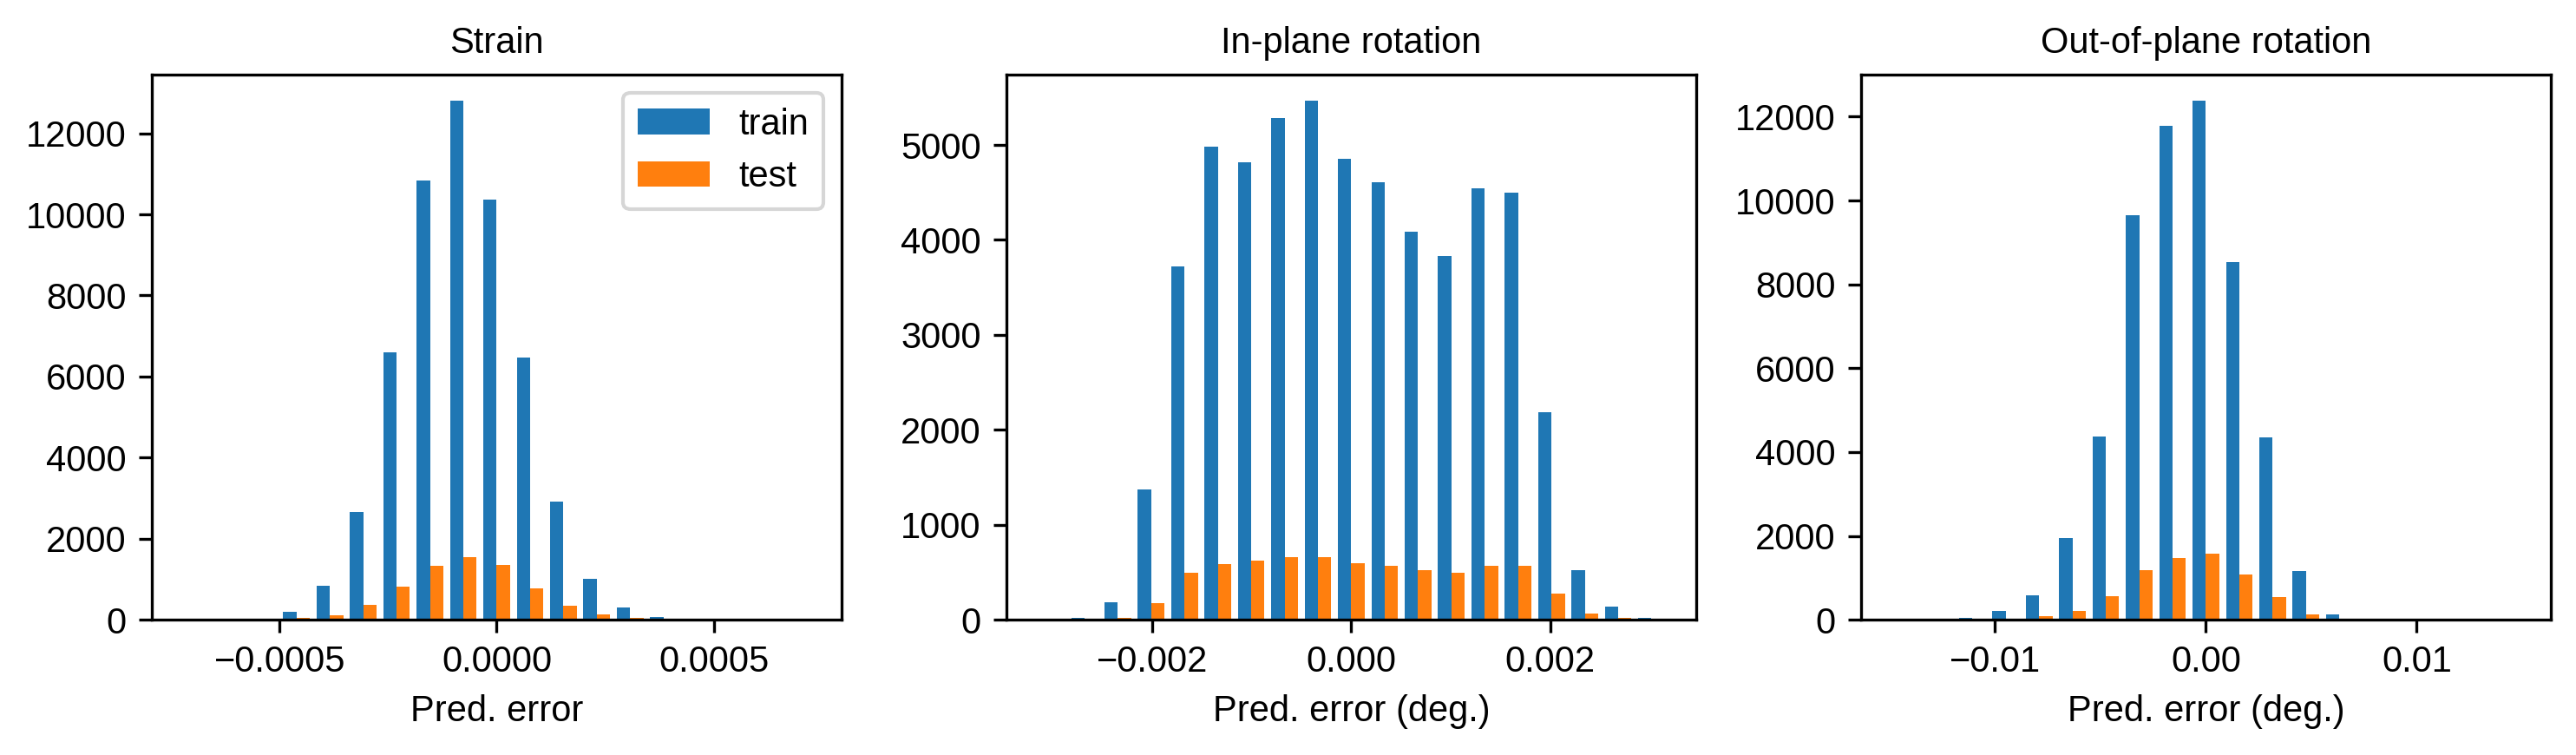

In [38]:
# Fig. S1b

matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(10, 3), ncols=3)

ax[0].hist([x0, y0], bins0, label=['train', 'test'])
ax[0].set_xlabel('Pred. error')
ax[0].set_title('Strain')
ax[0].legend()

ax[1].hist([x1, y1], bins1, label=['train', 'test'])
ax[1].set_xlabel('Pred. error (deg.)')
ax[1].set_title('In-plane rotation')

ax[2].hist([x2, y2], bins2, label=['train', 'test'])
ax[2].set_xlabel('Pred. error (deg.)')
ax[2].set_title('Out-of-plane rotation')

plt.tight_layout()
# f.savefig('figs1b.svg', dpi=300, bbox_inches='tight', transparent=True)

## DONUT trained on experimental data only

In [39]:
#cnn_exp = DonutNN2(1, 1) # Full model for image comparisons, 'best_model.pth'
cnn_exp = Encoder(1) # Encoder for fast inference, best_model_encoder.pth'
run_path = os.path.join(MODEL_SAVE_PATH, 'exp_only')
cnn_exp.load_state_dict(torch.load(os.path.join(run_path, 'best_model_encoder.pth')))
next(cnn_exp.parameters()).device

device(type='cpu')

In [40]:
pred_vals_exp_only, _ = get_predictions(cnn_exp, dataloader, encoder_only=True)

pred_strain_exp_only = np.reshape(pred_vals_exp_only[:, 0]/100, (165, 165))
pred_strain_exp_only -= np.mean(pred_strain_exp_only)
pred_tilt_lr_exp_only = np.reshape(pred_vals_exp_only[:, 1]/10, (165, 165))
pred_tilt_lr_exp_only -= np.mean(pred_tilt_lr_exp_only)
pred_tilt_ud_exp_only = np.reshape(pred_vals_exp_only[:, 2]/5, (165, 165))
pred_tilt_ud_exp_only -= np.mean(pred_tilt_ud_exp_only)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  2.1334855556488037
Average inference time (s):  6.76609720462487e-05
Inference time error (s):  1.6337365404840064e-06


[]

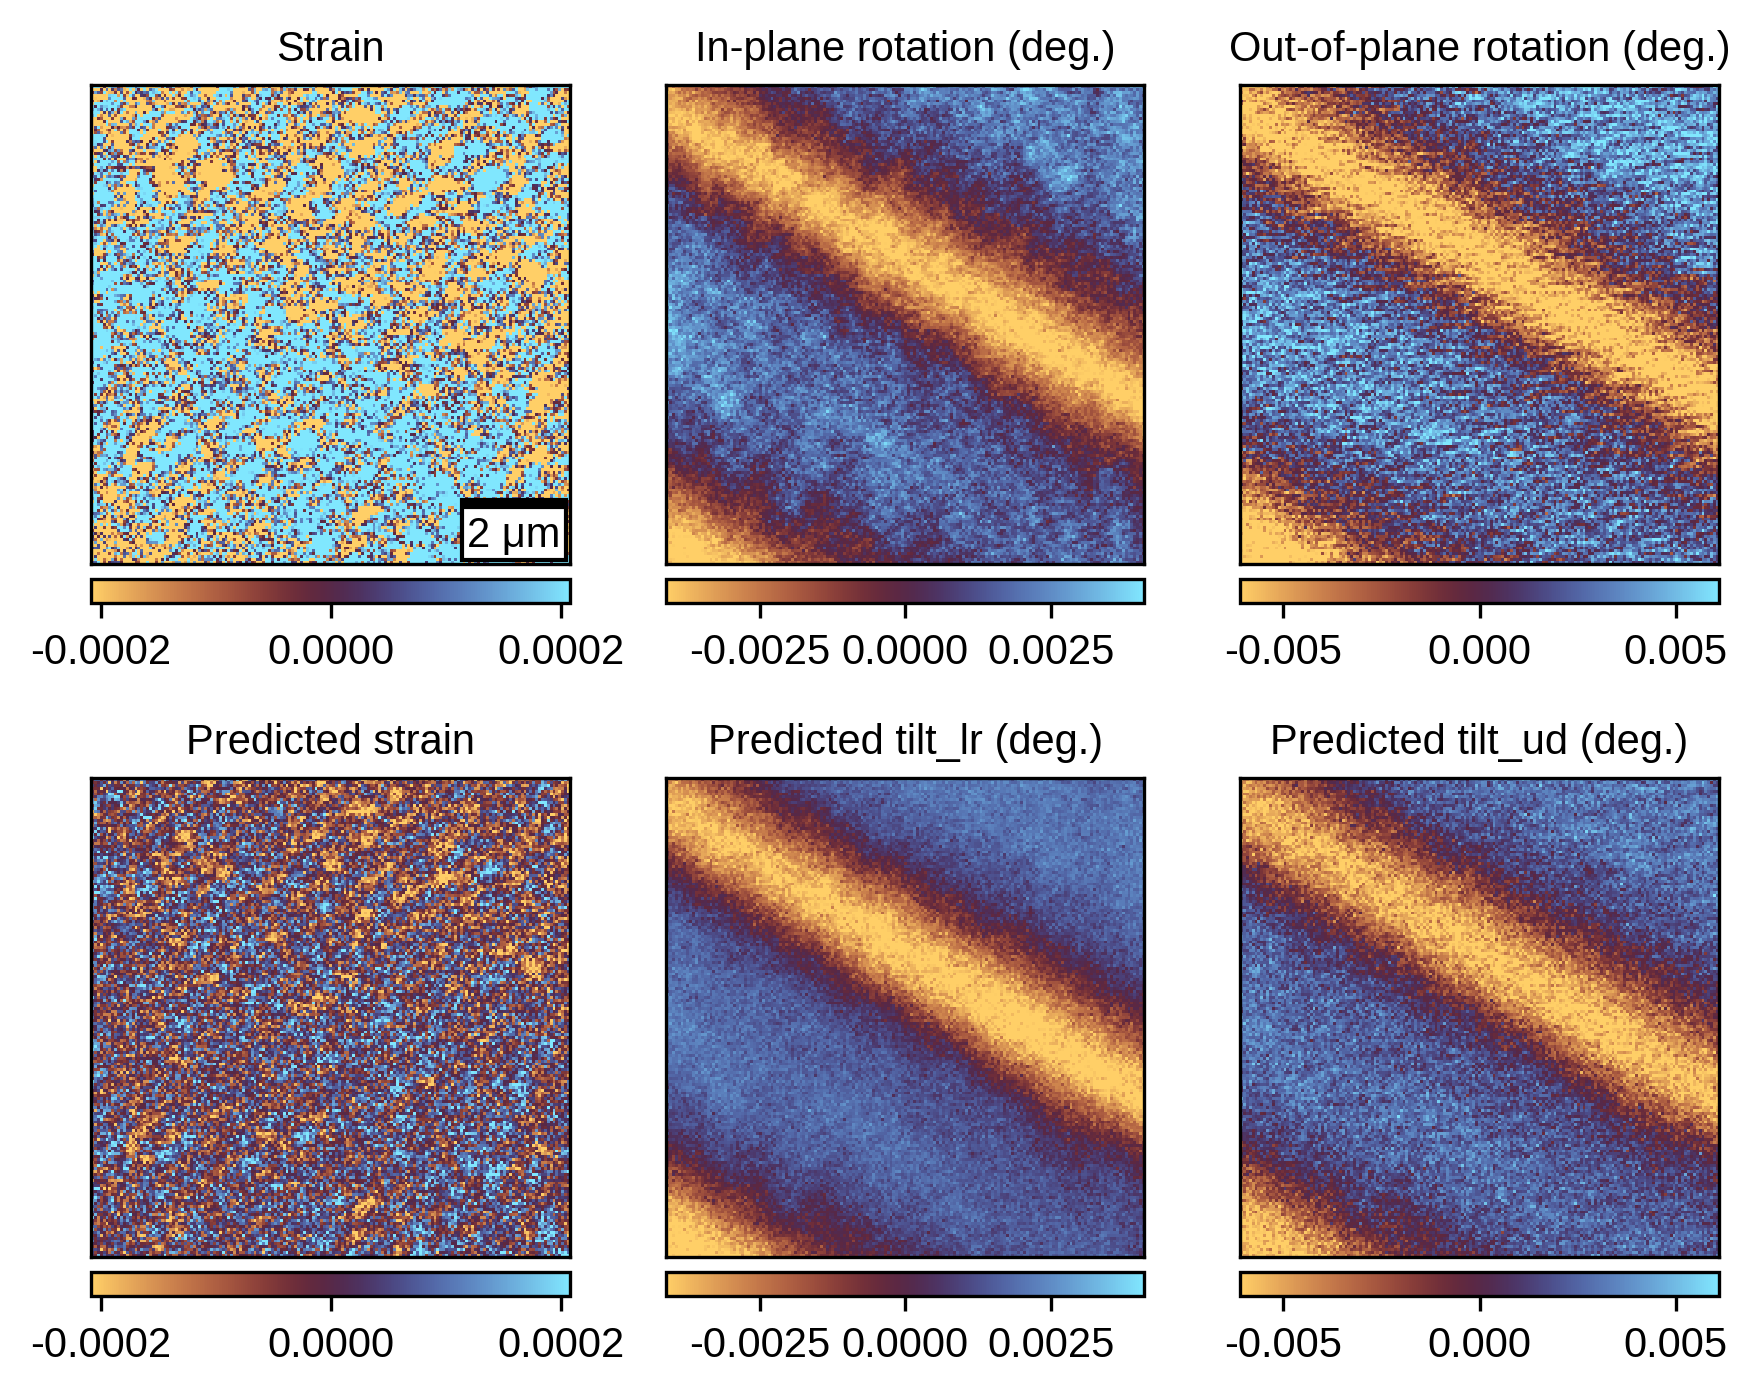

In [41]:
# Refer to Fig. S3a

matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 5.5), nrows=2, ncols=3)

vmin0 = np.mean(pred_strain_exp_only) - (2 * np.std(pred_strain_exp_only))
vmax0 = np.mean(pred_strain_exp_only) + (2 * np.std(pred_strain_exp_only))
vmin1 = np.mean(pred_tilt_lr_exp_only) - (2 * np.std(pred_tilt_lr_exp_only))
vmax1 = np.mean(pred_tilt_lr_exp_only) + (2 * np.std(pred_tilt_lr_exp_only))
vmin2 = np.mean(pred_tilt_ud_exp_only) - (2 * np.std(pred_tilt_ud_exp_only))
vmax2 = np.mean(pred_tilt_ud_exp_only) + (2 * np.std(pred_tilt_ud_exp_only))

im0 = ax[0, 0].imshow(strain, interpolation='none', origin='lower', vmin=vmin0, vmax=vmax0, 
                      cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal', format='%.4f')
scalebar = AnchoredSizeBar(ax[0, 0].transData, 33, u'2 μm', 'lower right', pad=0.1, color='black', 
                           frameon=True, size_vertical=1)

ax[0, 0].add_artist(scalebar)
ax[0, 0].set_title('Strain')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(tilt_lr, interpolation='none', origin='lower', vmin=vmin1, vmax=vmax1, 
                      cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('In-plane rotation (deg.)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(tilt_ud, interpolation='none', origin='lower', vmin=vmin2, vmax=vmax2, 
                      cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.3f')
ax[0, 2].set_title('Out-of-plane rotation (deg.)')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

pred0 = ax[1, 0].imshow(pred_strain_exp_only, interpolation='none', origin='lower', 
                        vmin=vmin0, vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred0, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 0].set_title('Predicted strain')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

pred1 = ax[1, 1].imshow(pred_tilt_lr_exp_only, interpolation='none', origin='lower', 
                        vmin=vmin1, vmax=vmax1, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Predicted tilt_lr (deg.)')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

pred2 = ax[1, 2].imshow(pred_tilt_ud_exp_only, interpolation='none', origin='lower', 
                        vmin=vmin2, vmax=vmax2, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred2, cax=cax, orientation='horizontal', format='%.3f')
ax[1, 2].set_title('Predicted tilt_ud (deg.)')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

#f.savefig('figs3a.svg', dpi=300, bbox_inches='tight', transparent=True)

## Comparison of training data

In [42]:
# Test predictions of each network on noisy simulated data, experimental training data
pred_vals_test_exp, _ = get_predictions(cnn_exp, testloader, encoder_only=True)

# Make arrays of mean and std. dev. of predictions for each parameter and label value for ease of plotting
test_stats_s_exp, test_stats_lr_exp, test_stats_ud_exp = combine_stats(test_s, test_lr, test_ud, pred_vals_test_exp)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.56642746925354
Average inference time (s):  6.950113957173356e-05
Inference time error (s):  1.1838961254084052e-06


In [43]:
# Trained on clean simulated + experimental data
cnn_sce = Encoder(1)
run_path = os.path.join(MODEL_SAVE_PATH, 'sim_clean_exp')
cnn_sce.load_state_dict(torch.load(os.path.join(run_path, 'best_model_encoder.pth')))

pred_vals_test_sce, _ = get_predictions(cnn_sce, testloader, encoder_only=True)

test_stats_s_sce, test_stats_lr_sce, test_stats_ud_sce = combine_stats(test_s, test_lr, test_ud, pred_vals_test_sce)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.5613613128662109
Average inference time (s):  6.892197878561288e-05
Inference time error (s):  1.1619985004645723e-06


In [44]:
# Trained on noisy simulated data only
cnn_noisy = Encoder(1)
run_path = os.path.join(MODEL_SAVE_PATH, 'sim_noisy')
cnn_noisy.load_state_dict(torch.load(os.path.join(run_path, 'best_model_encoder.pth')))

pred_vals_test_noisy, _ = get_predictions(cnn_noisy, testloader, encoder_only=True)

test_stats_s_noisy, test_stats_lr_noisy, test_stats_ud_noisy = combine_stats(test_s, test_lr, test_ud, 
                                                                             pred_vals_test_noisy)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.6512594223022461
Average inference time (s):  7.928068810534255e-05
Inference time error (s):  1.5471711837920112e-05


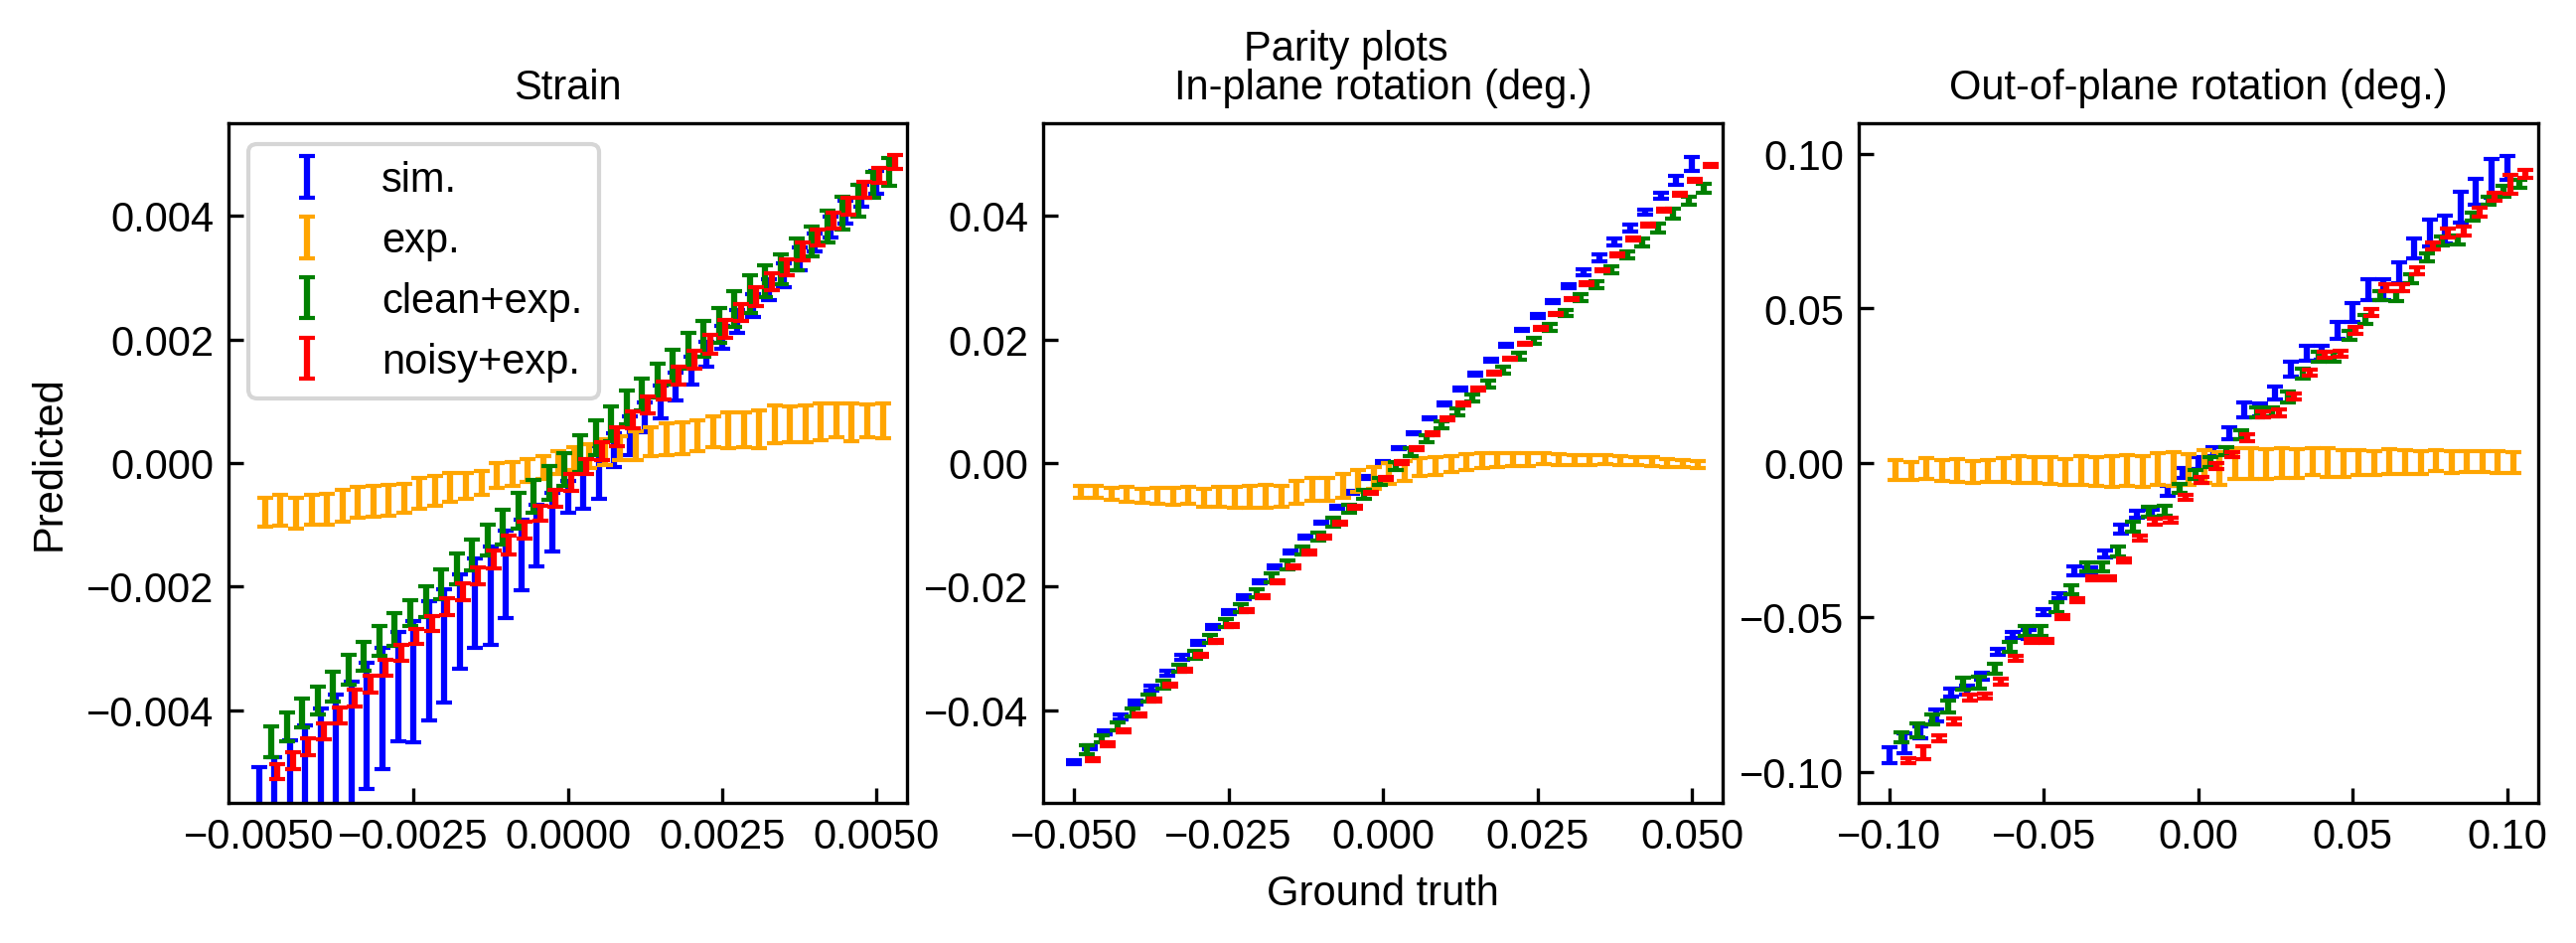

In [48]:
# Fig. S3b

matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(10, 3), ncols=3)

ax[0].errorbar(np.linspace(-0.005, 0.005, 41), test_stats_s_noisy[:, 0]/100, yerr=test_stats_s_noisy[:, 1]/100, 
               label='sim.', fmt='none', capsize=2, color='blue')
ax[0].errorbar(np.linspace(-0.005, 0.005, 41)+0.0001, test_stats_s_exp[:, 0]/100, 
               yerr=test_stats_s_exp[:, 1]/100, label='exp.', fmt='none', capsize=2, color='orange')
ax[0].errorbar(np.linspace(-0.005, 0.005, 41)+0.0002, test_stats_s_sce[:, 0]/100, 
               yerr=test_stats_s_sce[:, 1]/100, label='clean+exp.', fmt='none', capsize=2, color='green')
ax[0].errorbar(np.linspace(-0.005, 0.005, 41)+0.0003, test_stats_s[:, 0]/100, 
               yerr=test_stats_s[:, 1]/100, label='noisy+exp.', fmt='none', capsize=2, color='red')
ax[0].set_ylabel('Predicted')
ax[0].set_xlim([-0.0055, 0.0055])
ax[0].set_ylim([-0.0055, 0.0055])
ax[0].set_title('Strain')
ax[0].set_aspect(1)
ax[0].tick_params(which='both', direction='in')
ax[0].legend()

ax[1].errorbar(np.linspace(-0.05, 0.05, 41), test_stats_lr_noisy[:, 0]/10, yerr=test_stats_lr_noisy[:, 1]/10, 
               label='sim.', fmt='none', capsize=2, color='blue')
ax[1].errorbar(np.linspace(-0.05, 0.05, 41)+0.001, test_stats_lr_exp[:, 0]/10, yerr=test_stats_lr_exp[:, 1]/10, 
               label='exp.', fmt='none', capsize=2, color='orange')
ax[1].errorbar(np.linspace(-0.05, 0.05, 41)+0.002, test_stats_lr_sce[:, 0]/10, yerr=test_stats_lr_sce[:, 1]/10, 
               label='clean+exp.', fmt='none', capsize=2, color='green')
ax[1].errorbar(np.linspace(-0.05, 0.05, 41)+0.003, test_stats_lr[:, 0]/10, yerr=test_stats_lr[:, 1]/10, 
               label='noisy+exp.', fmt='none', capsize=2, color='red')
ax[1].set_xlabel('Ground truth')
ax[1].set_xlim([-0.055, 0.055])
ax[1].set_ylim([-0.055, 0.055])
ax[1].set_title('In-plane rotation (deg.)')
ax[1].tick_params(which='both', direction='in')
ax[1].set_aspect(1)

ax[2].errorbar(np.linspace(-0.1, 0.1, 41), test_stats_ud_noisy[:, 0]/5, yerr=test_stats_ud_noisy[:, 1]/5, 
               label='sim.', fmt='none', capsize=2, color='blue')
ax[2].errorbar(np.linspace(-0.1, 0.1, 41)+0.002, test_stats_ud_exp[:, 0]/5, yerr=test_stats_ud_exp[:, 1]/5, 
               label='exp.', fmt='none', capsize=2, color='orange')
ax[2].errorbar(np.linspace(-0.1, 0.1, 41)+0.004, test_stats_ud_sce[:, 0]/5, yerr=test_stats_ud_sce[:, 1]/5, 
               label='clean+exp.', fmt='none', capsize=2, color='green')
ax[2].errorbar(np.linspace(-0.1, 0.1, 41)+0.006, test_stats_ud[:, 0]/5, yerr=test_stats_ud[:, 1]/5, 
               label='noisy+exp.', fmt='none', capsize=2, color='red')
ax[2].set_title('Out-of-plane rotation (deg.)')
ax[2].set_xlim([-0.11, 0.11])
ax[2].set_ylim([-0.11, 0.11])
ax[2].tick_params(which='both', direction='in')
ax[2].set_aspect(1)

f.suptitle('Parity plots')
f.savefig('figs3b.svg', dpi=300, bbox_inches='tight', transparent=True)